# Flatiron Health aNSCLC: Relaxed trials with GBM crude

***OBJECTIVE:*** **Reproduce 5 landmark clinical trials in aNSCLC. Inclusion criteria for these trials will be pragmatically relaxed to allow for entry of our real-world patients, many of which would not meet criteria for inclusion in randomized controlled trials. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 

***OUTLINE:***
1. **Preprocessing**
2. **In silico trials:**
* KEYNOTE-042 
* KEYNOTE-024
* KEYNOTE-189 
* CHECKMATE-078
* FLAURA

## Part 1: Preprocessing

### 1.1 Import packages and create necessary functions

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
# Find index for value closest to input value. 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [4]:
# Calculates probability of survival at time t-months for risk groups. 
def psurv_t(low, med, high, t):
    low_t = low.survival_function_at_times(find_nearest(low.timeline, t)).values[0]*100
    med_t = med.survival_function_at_times(find_nearest(med.timeline, t)).values[0]*100
    high_t = high.survival_function_at_times(find_nearest(high.timeline, t)).values[0]*100
    pos_t = [low_t, med_t, high_t]
    return (pos_t)

In [5]:
# Calculates median overeall suvival for risk groups. 
def mos(low, med, high, comp):
    low_os = low.median_survival_time_
    med_os = med.median_survival_time_
    high_os = high.median_survival_time_
    comp_os = comp.median_survival_time_
    mos = [low_os, med_os, high_os, comp_os]
    return (mos)

In [6]:
# Calculates upper and lower 95% CI for median overall survival. 
def mos_ci(kmf):
    kmf_mos_low = (
        kmf.confidence_interval_[['KM_estimate_lower_0.95']]
        [kmf.confidence_interval_[['KM_estimate_lower_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_lower_0.95'], 0.5)]
        .idxmin()[0])

    kmf_mos_up = (
        kmf.confidence_interval_[['KM_estimate_upper_0.95']]
        [kmf.confidence_interval_[['KM_estimate_upper_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_upper_0.95'], 0.5)]
        .idxmin()[0])
    
    mos_ci = [kmf_mos_low, kmf_mos_up]
    return (mos_ci)

In [7]:
# Calculates upper and lower 95% CI for probability of survival at time t. 
def psurv_ci(kmf, t):
    kmf_psurv_ci_low = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][0]*100)

    kmf_psurv_ci_up = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][1]*100)
    
    psurv_ci = [kmf_psurv_ci_low, kmf_psurv_ci_up]
    return (psurv_ci)

In [8]:
# Calculate median overall survival or psurv error. 
def y_error(low_ci, med_ci, high_ci, surv_metric):
    error = [np.array([surv_metric[0] - low_ci[0],
                       surv_metric[1]- med_ci[0],
                       surv_metric[2] - high_ci[0]]),
               np.array([low_ci[1] - surv_metric[0],
                         med_ci[1] - surv_metric[1],
                         high_ci[1] - surv_metric[2]])]
    return(error)

In [9]:
# Cutoff decimlas to length n. 
def truncate(n, decimals = 0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

### 1.2 Process data 

In [10]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(54786, 54786)

In [11]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(13697, 13697)

In [12]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(68483, 68483)

In [13]:
crude_risk_score_df = pd.read_csv('crude_risk_score_df.csv')
row_ID(crude_risk_score_df)

(68483, 68483)

In [14]:
df = pd.merge(df, crude_risk_score_df, on = 'PatientID')
row_ID(df)

(68483, 68483)

In [15]:
df.to_csv('df_risk_crude.csv', index = False, header = True)

## Part 2: In-silico trials 

### KEYNOTE-042: First-line pembrolizumab vs. platinum-based chemotherapy in those with PDL1 >=1%

**INCLUSION CRITERIA**
* Untreated locally advanced or metastatic NSCLC
* Received first line pemobrolizumab or platinum-based chemotherapy (carboplatin + paclitaxel or carboplatin + pemetrexed)
* PDL1 >= 1% and status known within (-inf, +30] days of first-line treatment
* EGFR and ALK negative

#### Pembrolizumab

In [16]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [17]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [18]:
key042_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Pembrolizumab"')
    [['PatientID', 'StartDate']]
)

In [19]:
key042_pembro.loc[:, 'pembro'] = 1

In [20]:
row_ID(key042_pembro)

(3648, 3648)

In [21]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_042 = (
    line_therapy[line_therapy['PatientID'].isin(key042_pembro.PatientID)])

In [22]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [23]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_042_xcross = (
    line_therapy_pembro_042[line_therapy_pembro_042['LineName'].str.contains('|'.join(targeted))].PatientID)

In [24]:
# Select patients who don't receive targeted therapy in future lines.
key042_pembro = key042_pembro[~key042_pembro['PatientID'].isin(pembro_042_xcross)]

In [25]:
row_ID(key042_pembro)

(3582, 3582)

In [26]:
row_ID(key042_pembro)

(3582, 3582)

#### Platinum-based chemotherapy 

In [27]:
plat_chemo = [
    'Carboplatin,Paclitaxel',
    'Carboplatin,Pemetrexed',
    'Carboplatin,Paclitaxel Protein-Bound'
]

key042_plat = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == @plat_chemo')
    [['PatientID', 'StartDate']]
)

In [28]:
key042_plat.loc[:, 'pembro'] = 0

In [29]:
row_ID(key042_plat)

(15767, 15767)

In [30]:
# Dataframe of all therapies received for those receiving first line platinum regimen approved by KEY-042.  
line_therapy_plat_042 = (
    line_therapy[line_therapy['PatientID'].isin(key042_plat.PatientID)])

In [31]:
# Patients receiving platinum therapy who later recieve immunotherapy or targeted therapy. 
plat_042_xcross = (
    line_therapy_plat_042[line_therapy_plat_042['LineName'].str.contains('|'.join(targeted))].PatientID)

In [32]:
# Select patients who don't receive targeted therapy, immunotherapy, or clinical study drug in future lines.
key042_plat = key042_plat[~key042_plat['PatientID'].isin(plat_042_xcross)]

In [33]:
row_ID(key042_plat)

(14634, 14634)

In [34]:
key_042 = pd.concat([key042_pembro, key042_plat])

In [35]:
row_ID(key_042)

(18216, 18216)

In [36]:
key_042 = pd.merge(key_042, df_full, on = 'PatientID', how = 'inner')

In [37]:
row_ID(key_042)

(18216, 18216)

In [38]:
key_042['StartDate'] = pd.to_datetime(key_042['StartDate'])

#### PDL1 >=1%

In [39]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [40]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(key_042['PatientID'])]

In [41]:
biomarkers = pd.merge(biomarkers, key_042[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [42]:
row_ID(biomarkers)

(66561, 13487)

In [43]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [44]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [45]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [46]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [47]:
pdl1_ids = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <=30')
    .query('PercentStaining != "0%" and PercentStaining != "< 1%" and PercentStaining.notnull()', engine = 'python')
    .PatientID
    .unique()
)

In [48]:
key_042 = key_042[key_042.PatientID.isin(pdl1_ids)]

In [49]:
row_ID(key_042)

(4851, 4851)

#### Time from treatment to death or censor

In [50]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [51]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [52]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [53]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [54]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [55]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [56]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [57]:
key_042 = pd.merge(key_042, mortality, on = 'PatientID')

In [58]:
row_ID(key_042)

(4851, 4851)

In [59]:
conditions = [
    (key_042['death_status'] == 1),
    (key_042['death_status'] == 0)]

choices = [
    (key_042['death_date'] - key_042['StartDate']).dt.days,
    (key_042['last_activity'] - key_042['StartDate']).dt.days]

key_042.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [60]:
key_042 = key_042.query('timerisk_treatment >= 0')

#### Patient count

In [61]:
key_042 = (
    key_042
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [62]:
low_cutoff_042 = key_042.risk_score.quantile(1/3)

In [63]:
high_cutoff_042 = key_042.risk_score.quantile(2/3)

In [64]:
print('Pembro total:',  key_042.query('pembro == 1').shape[0])
print('High risk:', key_042.query('pembro == 1').query('risk_score >= @high_cutoff_042').shape[0])
print('Med risk:', key_042.query('pembro == 1').query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042').shape[0])
print('Low risk:', key_042.query('pembro == 1').query('risk_score <= @low_cutoff_042').shape[0])

Pembro total: 2914
High risk: 1030
Med risk: 984
Low risk: 900


In [65]:
print('Platinum total:',  key_042.query('pembro == 0').shape[0])
print('High risk:', key_042.query('pembro == 0').query('risk_score >= @high_cutoff_042').shape[0])
print('Med risk:', key_042.query('pembro == 0').query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042').shape[0])
print('Low risk:', key_042.query('pembro == 0').query('risk_score <= @low_cutoff_042').shape[0])

Platinum total: 1828
High risk: 551
Med risk: 596
Low risk: 681


In [66]:
data = {'low': [low_cutoff_042],
        'high': [high_cutoff_042]}

risk_cutoff_lung = pd.DataFrame(data = data, index = ['keynote_042'])

#### Survival curves without confounder adjustment 

In [67]:
key_042 = key_042.set_index('PatientID')

In [68]:
key042_low_pembro = (
    key_042
    .query('pembro == 1')
    .query('risk_score <= @low_cutoff_042')
    .index)

key042_low_plat = (
    key_042
    .query('pembro == 0')
    .query('risk_score <= @low_cutoff_042')
    .index)

key042_med_pembro = (
    key_042
    .query('pembro == 1')
    .query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042')
    .index)

key042_med_plat = (
    key_042
    .query('pembro == 0')
    .query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042')
    .index)

key042_high_pembro = (
    key_042
    .query('pembro == 1')
    .query('risk_score >= @high_cutoff_042')
    .index)

key042_high_plat = (
    key_042
    .query('pembro == 0')
    .query('risk_score >= @high_cutoff_042')
    .index)

key042_all_pembro = (
    key_042
    .query('pembro == 1')
    .index)

key042_all_plat = (
    key_042
    .query('pembro == 0')
    .index)

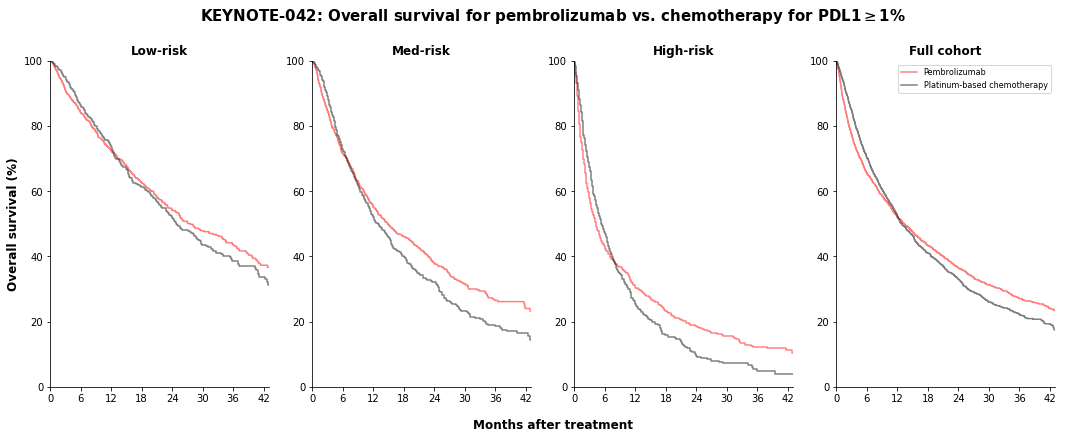

In [69]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_pembro_042, survival_prob_low_pembro_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_low_pembro]['death_status']),
                                                                           np.array(key_042.loc[key042_low_pembro]['timerisk_treatment']))

time_low_plat_042, survival_prob_low_plat_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_low_plat]['death_status']),
                                                                       np.array(key_042.loc[key042_low_plat]['timerisk_treatment']))

plt.step(time_low_pembro_042/30, survival_prob_low_pembro_042*100, color = 'red', alpha = 0.5)
plt.step(time_low_plat_042/30, survival_prob_low_plat_042*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_pembro_042, survival_prob_med_pembro_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_med_pembro]['death_status']),
                                                                           np.array(key_042.loc[key042_med_pembro]['timerisk_treatment']))

time_med_plat_042, survival_prob_med_plat_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_med_plat]['death_status']),
                                                                       np.array(key_042.loc[key042_med_plat]['timerisk_treatment']))

plt.step(time_med_pembro_042/30, survival_prob_med_pembro_042*100, color = 'red', alpha = 0.5)

plt.step(time_med_plat_042/30, survival_prob_med_plat_042*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_pembro_042, survival_prob_high_pembro_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_high_pembro]['death_status']),
                                                                             np.array(key_042.loc[key042_high_pembro]['timerisk_treatment']))

time_high_plat_042, survival_prob_high_plat_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_high_plat]['death_status']),
                                                                         np.array(key_042.loc[key042_high_plat]['timerisk_treatment']))

plt.step(time_high_pembro_042/30, survival_prob_high_pembro_042*100, color = 'red', alpha = 0.5)

plt.step(time_high_plat_042/30, survival_prob_high_plat_042*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatmetn for all 
plt.subplot(1, 4, 4)

time_all_pembro_042, survival_prob_all_pembro_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_all_pembro]['death_status']),
                                                                           np.array(key_042.loc[key042_all_pembro]['timerisk_treatment']))

time_all_plat_042, survival_prob_all_plat_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_all_plat]['death_status']),
                                                                       np.array(key_042.loc[key042_all_plat]['timerisk_treatment']))

plt.step(time_all_pembro_042/30, survival_prob_all_pembro_042*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(time_all_plat_042/30, survival_prob_all_plat_042*100, color = 'black', alpha = 0.5, label = 'Platinum-based chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-042: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$1%', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival curves with confounder adjustment via IPTW

In [70]:
key_042_iptw = key_042.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'steroid_diag',
                                       'opioid_PO_diag',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'risk_score'])

In [71]:
key_042_iptw.dtypes

death_status             bool
timerisk_treatment    float64
pembro                  int64
age                     int64
gender                 object
race                   object
PracticeType           object
Histology              object
adv_year                int64
steroid_diag          float64
opioid_PO_diag        float64
commercial            float64
medicare              float64
medicaid              float64
risk_score            float64
dtype: object

In [72]:
to_be_categorical = list(key_042_iptw.select_dtypes(include = ['object']).columns)

In [73]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology']

In [74]:
to_be_categorical.append('adv_year')

In [75]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_042_iptw[x] = key_042_iptw[x].astype('category')

In [76]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [77]:
# List of categorical features.
categorical_features = list(key_042_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [78]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [79]:
key_042_iptw_low = (
    key_042_iptw
    .query('risk_score <= @low_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_med = (
    key_042_iptw
    .query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_high = (
    key_042_iptw
    .query('risk_score >= @high_cutoff_042')
    .drop(columns = ['risk_score']))

In [80]:
key_042_low_x = preprocessor.fit_transform(key_042_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'steroid_diag',
                                                                            'opioid_PO_diag',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid']))

key_042_med_x = preprocessor.fit_transform(key_042_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'steroid_diag',
                                                                            'opioid_PO_diag',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid']))

key_042_high_x = preprocessor.fit_transform(key_042_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'adv_year',
                                                                              'steroid_diag',
                                                                              'opioid_PO_diag',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid']))

In [81]:
lr_042_low = LogisticRegression(max_iter = 1000)
lr_042_low.fit(key_042_low_x, key_042_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [82]:
lr_042_med = LogisticRegression(max_iter = 1000)
lr_042_med.fit(key_042_med_x, key_042_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [83]:
lr_042_high = LogisticRegression(max_iter = 1000)
lr_042_high.fit(key_042_high_x, key_042_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [84]:
pred_low = lr_042_low.predict_proba(key_042_low_x)
pred_med = lr_042_med.predict_proba(key_042_med_x)
pred_high = lr_042_high.predict_proba(key_042_high_x)

In [85]:
key_042_iptw_low['ps'] = pred_low[:, 1]
key_042_iptw_med['ps'] = pred_med[:, 1]
key_042_iptw_high['ps'] = pred_high[:, 1]

In [86]:
key_042_iptw_low['weight'] = (
    np.where(key_042_iptw_low['pembro'] == 1, 1/key_042_iptw_low['ps'], 1/(1 - key_042_iptw_low['ps'])))

key_042_iptw_med['weight'] = (
    np.where(key_042_iptw_med['pembro'] == 1, 1/key_042_iptw_med['ps'], 1/(1 - key_042_iptw_med['ps'])))

key_042_iptw_high['weight'] = (
    np.where(key_042_iptw_high['pembro'] == 1, 1/key_042_iptw_high['ps'], 1/(1 - key_042_iptw_high['ps'])))

In [87]:
key_042_iptw_all = pd.concat([key_042_iptw_low, key_042_iptw_med, key_042_iptw_high])

In [88]:
# Low KM curves
kmf_low_pembro_042_iptw = KaplanMeierFitter()
kmf_low_plat_042_iptw = KaplanMeierFitter()

kmf_low_pembro_042_iptw.fit(
    key_042_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_low.query('pembro == 1').death_status,
    weights = key_042_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_042_iptw.fit(
    key_042_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_low.query('pembro == 0').death_status,
    weights = key_042_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_042_iptw = KaplanMeierFitter()
kmf_med_plat_042_iptw = KaplanMeierFitter()

kmf_med_pembro_042_iptw.fit(
    key_042_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_med.query('pembro == 1').death_status,
    weights = key_042_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_042_iptw.fit(
    key_042_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_med.query('pembro == 0').death_status,
    weights = key_042_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_042_iptw = KaplanMeierFitter()
kmf_high_plat_042_iptw = KaplanMeierFitter()

kmf_high_pembro_042_iptw.fit(
    key_042_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_high.query('pembro == 1').death_status,
    weights = key_042_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_042_iptw.fit(
    key_042_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_high.query('pembro == 0').death_status,
    weights = key_042_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_042_iptw = KaplanMeierFitter()
kmf_all_plat_042_iptw = KaplanMeierFitter()

kmf_all_pembro_042_iptw.fit(
    key_042_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_all.query('pembro == 1').death_status,
    weights = key_042_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_042_iptw.fit(
    key_042_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_all.query('pembro == 0').death_status,
    weights = key_042_iptw_all.query('pembro == 0')['weight'])

/Applications/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4699.47 total observations, 1852.56 right-censored observations>

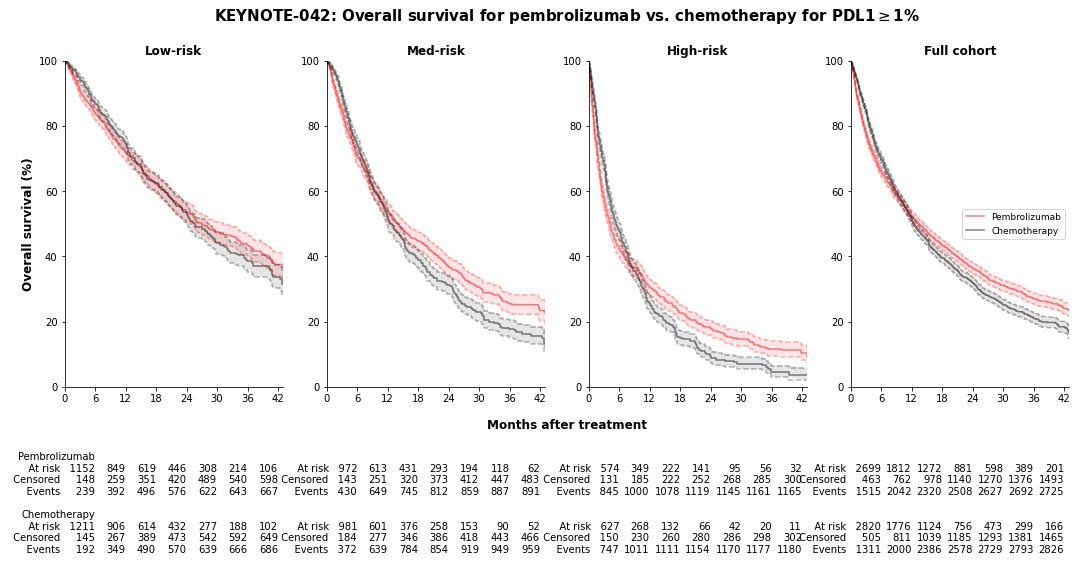

In [89]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_042_iptw.timeline, kmf_low_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
plt.step(kmf_low_pembro_042_iptw.confidence_interval_.index, np.array(kmf_low_pembro_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_low_pembro_042_iptw.confidence_interval_.index, np.array(kmf_low_pembro_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_low_pembro_042_iptw.timeline, np.array(kmf_low_pembro_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_pembro_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_plat_042_iptw.timeline, kmf_low_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
plt.step(kmf_low_plat_042_iptw.confidence_interval_.index, np.array(kmf_low_plat_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_low_plat_042_iptw.confidence_interval_.index, np.array(kmf_low_plat_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_low_plat_042_iptw.timeline, np.array(kmf_low_plat_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_plat_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_pembro_042_iptw, kmf_low_plat_042_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = ['Pembrolizumab', 'Chemotherapy'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_042_iptw.timeline, kmf_med_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
plt.step(kmf_med_pembro_042_iptw.confidence_interval_.index, np.array(kmf_med_pembro_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_med_pembro_042_iptw.confidence_interval_.index, np.array(kmf_med_pembro_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_med_pembro_042_iptw.timeline, np.array(kmf_med_pembro_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_pembro_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_plat_042_iptw.timeline, kmf_med_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
plt.step(kmf_med_plat_042_iptw.confidence_interval_.index, np.array(kmf_med_plat_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_med_plat_042_iptw.confidence_interval_.index, np.array(kmf_med_plat_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_med_plat_042_iptw.timeline, np.array(kmf_med_plat_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_plat_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_pembro_042_iptw, kmf_med_plat_042_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_042_iptw.timeline, kmf_high_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
plt.step(kmf_high_pembro_042_iptw.confidence_interval_.index, np.array(kmf_high_pembro_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_high_pembro_042_iptw.confidence_interval_.index, np.array(kmf_high_pembro_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_high_pembro_042_iptw.timeline, np.array(kmf_high_pembro_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_pembro_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_plat_042_iptw.timeline, kmf_high_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
plt.step(kmf_high_plat_042_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_plat_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_high_plat_042_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_plat_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_high_plat_042_iptw.timeline[:-1], (np.array(kmf_high_plat_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], (np.array(kmf_high_plat_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_pembro_042_iptw, kmf_high_plat_042_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_042_iptw.timeline, kmf_all_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')
plt.step(kmf_all_pembro_042_iptw.confidence_interval_.index, np.array(kmf_all_pembro_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_all_pembro_042_iptw.confidence_interval_.index, np.array(kmf_all_pembro_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_all_pembro_042_iptw.timeline, np.array(kmf_all_pembro_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_pembro_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_plat_042_iptw.timeline, kmf_all_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')
plt.step(kmf_all_plat_042_iptw.confidence_interval_.index, np.array(kmf_all_plat_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_all_plat_042_iptw.confidence_interval_.index, np.array(kmf_all_plat_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_all_plat_042_iptw.timeline, np.array(kmf_all_plat_042_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_plat_042_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_pembro_042_iptw, kmf_all_plat_042_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-042: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$1%', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [90]:
pembro_042_12_os = psurv_t(kmf_low_pembro_042_iptw, 
                           kmf_med_pembro_042_iptw,
                           kmf_high_pembro_042_iptw,
                           12)

plat_042_12_os = psurv_t(kmf_low_plat_042_iptw,
                         kmf_med_plat_042_iptw,
                         kmf_high_plat_042_iptw,
                         12)

pembro_042_24_os = psurv_t(kmf_low_pembro_042_iptw, 
                           kmf_med_pembro_042_iptw,
                           kmf_high_pembro_042_iptw,
                           24)

plat_042_24_os = psurv_t(kmf_low_plat_042_iptw,
                         kmf_med_plat_042_iptw,
                         kmf_high_plat_042_iptw,
                         24)

pembro_042_median_os = mos(kmf_low_pembro_042_iptw,
                           kmf_med_pembro_042_iptw,
                           kmf_high_pembro_042_iptw,
                           kmf_all_pembro_042_iptw)

plat_042_median_os = mos(kmf_low_plat_042_iptw,
                         kmf_med_plat_042_iptw,
                         kmf_high_plat_042_iptw,
                         kmf_all_plat_042_iptw)

In [91]:
print('All, pembro: ',truncate(pembro_042_median_os[3], 3))
print('All, platinum: ',truncate(plat_042_median_os[3], 3))

print('Low, pembro: ',truncate(pembro_042_median_os[0], 3))
print('Low, platinum: ',truncate(plat_042_median_os[0], 3))

print('Med, pembro: ',truncate(pembro_042_median_os[1], 3))
print('Med, platinum: ',truncate(plat_042_median_os[1], 3))

print('High, pembro: ',truncate(pembro_042_median_os[2], 3))
print('High, platinum: ',truncate(plat_042_median_os[2], 3))

All, pembro:  13.466
All, platinum:  12.4
Low, pembro:  27.066
Low, platinum:  25.7
Med, pembro:  14.233
Med, platinum:  12.9
High, pembro:  4.2
High, platinum:  5.466


In [92]:
pembro_042_low_12_ci = psurv_ci(kmf_low_pembro_042_iptw, 12)
pembro_042_med_12_ci = psurv_ci(kmf_med_pembro_042_iptw, 12)
pembro_042_high_12_ci = psurv_ci(kmf_high_pembro_042_iptw, 12)

y_error_pembro_042_12 = y_error(pembro_042_low_12_ci,
                                pembro_042_med_12_ci,
                                pembro_042_high_12_ci,
                                pembro_042_12_os)

In [93]:
plat_042_low_12_ci = psurv_ci(kmf_low_plat_042_iptw, 12)
plat_042_med_12_ci = psurv_ci(kmf_med_plat_042_iptw, 12)
plat_042_high_12_ci = psurv_ci(kmf_high_plat_042_iptw, 12)

y_error_plat_042_12 = y_error(plat_042_low_12_ci,
                              plat_042_med_12_ci,
                              plat_042_high_12_ci,
                              plat_042_12_os)

In [94]:
pembro_042_low_24_ci = psurv_ci(kmf_low_pembro_042_iptw, 24)
pembro_042_med_24_ci = psurv_ci(kmf_med_pembro_042_iptw, 24)
pembro_042_high_24_ci = psurv_ci(kmf_high_pembro_042_iptw, 24)

y_error_pembro_042_24 = y_error(pembro_042_low_24_ci,
                                pembro_042_med_24_ci,
                                pembro_042_high_24_ci,
                                pembro_042_24_os)

In [95]:
plat_042_low_24_ci = psurv_ci(kmf_low_plat_042_iptw, 24)
plat_042_med_24_ci = psurv_ci(kmf_med_plat_042_iptw, 24)
plat_042_high_24_ci = psurv_ci(kmf_high_plat_042_iptw, 24)

y_error_plat_042_24 = y_error(plat_042_low_24_ci,
                              plat_042_med_24_ci,
                              plat_042_high_24_ci,
                              plat_042_24_os)

In [96]:
pembro_042_low_mos_ci = mos_ci(kmf_low_pembro_042_iptw)
pembro_042_med_mos_ci = mos_ci(kmf_med_pembro_042_iptw)
pembro_042_high_mos_ci = mos_ci(kmf_high_pembro_042_iptw)

y_error_pembro_042_mos = y_error(pembro_042_low_mos_ci,
                                 pembro_042_med_mos_ci,
                                 pembro_042_high_mos_ci,
                                 pembro_042_median_os)

In [97]:
plat_042_low_mos_ci = mos_ci(kmf_low_plat_042_iptw)
plat_042_med_mos_ci = mos_ci(kmf_med_plat_042_iptw)
plat_042_high_mos_ci = mos_ci(kmf_high_plat_042_iptw)

y_error_plat_042_mos = y_error(plat_042_low_mos_ci,
                               plat_042_med_mos_ci,
                               plat_042_high_mos_ci,
                               plat_042_median_os)

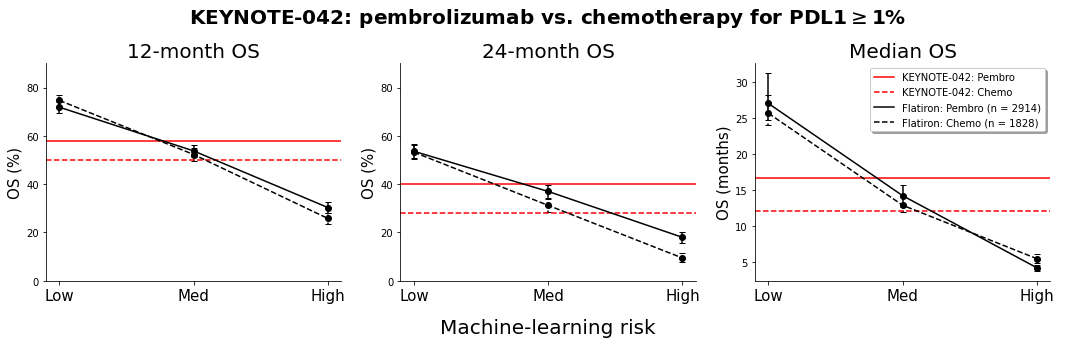

In [98]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, pembro_042_12_os, yerr = y_error_pembro_042_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 58, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, plat_042_12_os, yerr = y_error_plat_042_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 50, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('12-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, pembro_042_24_os, yerr = y_error_pembro_042_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 40, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, plat_042_24_os, yerr = y_error_plat_042_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 28, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, pembro_042_median_os[0:3], yerr = y_error_pembro_042_mos, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 16.7, color = 'red', linestyle = 'solid')

eb3 = plt.errorbar(ml_risk, plat_042_median_os[0:3], yerr = y_error_plat_042_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')
plt.axhline(y = 12.1, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title(r'KEYNOTE-042: pembrolizumab vs. chemotherapy for PDL1$\geq$1%', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'KEYNOTE-042: Pembro'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'KEYNOTE-042: Chemo'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Pembro (n = {})'.format(key_042.query('pembro == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Chemo (n = {})'.format(key_042.query('pembro == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'upper right', prop = {'size': 10})

#plt.savefig('key042_summary_rc.png', bbox_inches = 'tight')

plt.show()

### KEYNOTE-024: First-line pembrolizumab vs. platinum-based chemotherapy in those with high PDL1 

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line pemobrolizumab or platinum-based chemotherapy (carboplatin + paclitaxel, carboplatin + pemetrexed, carboplatin + gemcitabine, cisplatin + pemetrexed,  or cisplatin + gemcitabine)
* PDL1 >= 50% and status known within (-inf, +30] days of start of first-line treatment 
* EGFR and ALK negatve

#### Pembrolizumab

In [99]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [100]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [101]:
key024_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Pembrolizumab"')
    [['PatientID', 'StartDate']]
)

In [102]:
key024_pembro.loc[:, 'pembro'] = 1

In [103]:
row_ID(key024_pembro)

(3648, 3648)

In [104]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_024 = (
    line_therapy[line_therapy['PatientID'].isin(key024_pembro.PatientID)])

In [105]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [106]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_024_xcross = (
    line_therapy_pembro_024[line_therapy_pembro_024['LineName'].str.contains('|'.join(targeted))].PatientID)

In [107]:
# Select patients who don't receive targeted therapy in future lines.
key024_pembro = key024_pembro[~key024_pembro['PatientID'].isin(pembro_024_xcross)]

In [108]:
row_ID(key024_pembro)

(3582, 3582)

#### Platinum-based chemotherapy 

In [109]:
plat_chemo = [
    'Carboplatin,Paclitaxel',
    'Carboplatin,Paclitaxel Protein-Bound',
    'Carboplatin,Pemetrexed',
    'Carboplatin,Gemcitabine',
    'Cisplatin,Pemetrexed',
    'Cisplatin,Gemcitabine'
]

key024_plat = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == @plat_chemo')
    [['PatientID', 'StartDate']]
)

In [110]:
key024_plat.loc[:, 'pembro'] = 0

In [111]:
row_ID(key024_plat)

(17905, 17905)

In [112]:
# Dataframe of all therapies received for those receiving first line platinum regimen approved by KEY-042.  
line_therapy_plat_024 = (
    line_therapy[line_therapy['PatientID'].isin(key024_plat.PatientID)])

In [113]:
# Patients receiving platinum therapy who later recieve immunotherapy or targeted therapy. 
plat_024_xcross = (
    line_therapy_plat_024[line_therapy_plat_024['LineName'].str.contains('|'.join(targeted))].PatientID)

In [114]:
# Select patients who don't receive targeted therapy, immunotherapy, or clinical study drug in future lines.
key024_plat = key024_plat[~key024_plat['PatientID'].isin(plat_024_xcross)]

In [115]:
row_ID(key024_plat)

(16608, 16608)

In [116]:
key_024 = pd.concat([key024_pembro, key024_plat])

In [117]:
row_ID(key_024)

(20190, 20190)

In [118]:
key_024 = pd.merge(key_024, df_full, on = 'PatientID', how = 'inner')

In [119]:
row_ID(key_024)

(20190, 20190)

In [120]:
key_024['StartDate'] = pd.to_datetime(key_024['StartDate'])

#### High PDL1

In [121]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [122]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(key_024['PatientID'])]

In [123]:
biomarkers = pd.merge(biomarkers, key_024[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [124]:
row_ID(biomarkers)

(71683, 14642)

In [125]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [126]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [127]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [128]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [129]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [130]:
lst = ["50% - 59%", "60% - 69%", "70% - 79%", "80% - 89%", "90% - 99%", "100%"]

pdl1_ids = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <=30')
    .query('PercentStaining == @lst')
    .PatientID
    .unique()
)

In [131]:
key_024 = key_024[key_024.PatientID.isin(pdl1_ids)]

In [132]:
row_ID(key_024)

(3327, 3327)

#### Time from treatment to death or censor

In [133]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [134]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [135]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [136]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [137]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [138]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [139]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [140]:
key_024 = pd.merge(key_024, mortality, on = 'PatientID')

In [141]:
row_ID(key_024)

(3327, 3327)

In [142]:
conditions = [
    (key_024['death_status'] == 1),
    (key_024['death_status'] == 0)]

choices = [
    (key_024['death_date'] - key_024['StartDate']).dt.days,
    (key_024['last_activity'] - key_024['StartDate']).dt.days]

key_024.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [143]:
key_024 = key_024.query('timerisk_treatment >= 0')

#### Patient counts

In [144]:
key_024 = (
    key_024
    .query('stage == "IV"')
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [145]:
low_cutoff_024 = key_024.risk_score.quantile(1/3)

In [146]:
high_cutoff_024 = key_024.risk_score.quantile(2/3)

In [147]:
print('Pembro total:',  key_024.query('pembro == 1').shape[0])
print('High risk:', key_024.query('pembro == 1').query('risk_score >= @high_cutoff_024').shape[0])
print('Med risk:', key_024.query('pembro == 1').query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024').shape[0])
print('Low risk:', key_024.query('pembro == 1').query('risk_score <= @low_cutoff_024').shape[0])

Pembro total: 1786
High risk: 581
Med risk: 611
Low risk: 594


In [148]:
print('Platinum total:',  key_024.query('pembro == 0').shape[0])
print('High risk:', key_024.query('pembro == 0').query('risk_score >= @high_cutoff_024').shape[0])
print('Med risk:', key_024.query('pembro == 0').query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024').shape[0])
print('Low risk:', key_024.query('pembro == 0').query('risk_score <= @low_cutoff_024').shape[0])

Platinum total: 381
High risk: 142
Med risk: 110
Low risk: 129


In [149]:
risk_cutoff_lung.loc['keynote_024'] = [low_cutoff_024, high_cutoff_024]

#### Survival curves without confounder adjustment

In [150]:
key_024 = key_024.set_index('PatientID')

In [151]:
key024_low_pembro = (
    key_024
    .query('pembro == 1')
    .query('risk_score <= @low_cutoff_024')
    .index)

key024_low_plat = (
    key_024
    .query('pembro == 0')
    .query('risk_score <= @low_cutoff_024')
    .index)

key024_med_pembro = (
    key_024
    .query('pembro == 1')
    .query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024')
    .index)

key024_med_plat = (
    key_024
    .query('pembro == 0')
    .query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024')
    .index)

key024_high_pembro = (
    key_024
    .query('pembro == 1')
    .query('risk_score >= @high_cutoff_024')
    .index)

key024_high_plat = (
    key_024
    .query('pembro == 0')
    .query('risk_score >= @high_cutoff_024')
    .index)

key024_all_pembro = (
    key_024
    .query('pembro == 1')
    .index)

key024_all_plat = (
    key_024
    .query('pembro == 0')
    .index)

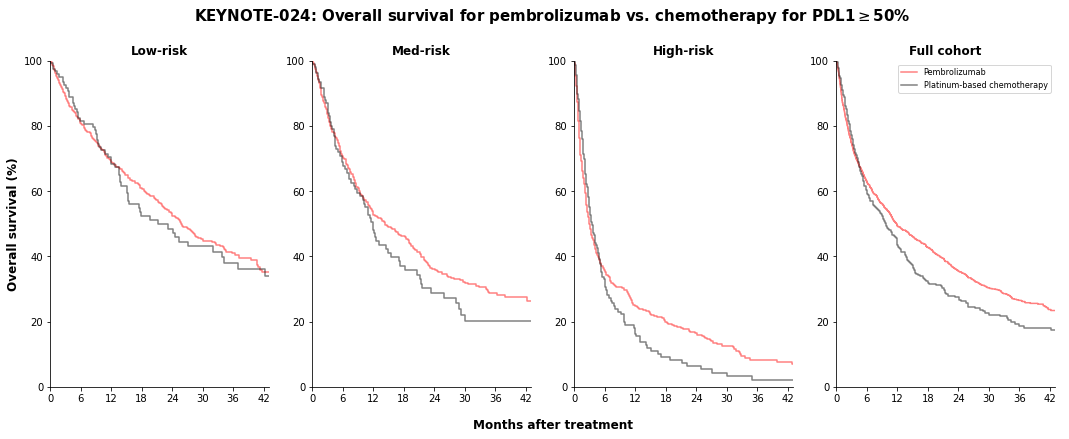

In [152]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_pembro_024, survival_prob_low_pembro_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_low_pembro]['death_status']),
                                                                           np.array(key_024.loc[key024_low_pembro]['timerisk_treatment']))

time_low_plat_024, survival_prob_low_plat_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_low_plat]['death_status']),
                                                                       np.array(key_024.loc[key024_low_plat]['timerisk_treatment']))

plt.step(time_low_pembro_024/30, survival_prob_low_pembro_024*100, color = 'red', alpha = 0.5)
plt.step(time_low_plat_024/30, survival_prob_low_plat_024*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_pembro_024, survival_prob_med_pembro_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_med_pembro]['death_status']),
                                                                           np.array(key_024.loc[key024_med_pembro]['timerisk_treatment']))

time_med_plat_024, survival_prob_med_plat_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_med_plat]['death_status']),
                                                                       np.array(key_024.loc[key024_med_plat]['timerisk_treatment']))

plt.step(time_med_pembro_024/30, survival_prob_med_pembro_024*100, color = 'red', alpha = 0.5)

plt.step(time_med_plat_024/30, survival_prob_med_plat_024*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_pembro_024, survival_prob_high_pembro_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_high_pembro]['death_status']),
                                                                             np.array(key_024.loc[key024_high_pembro]['timerisk_treatment']))

time_high_plat_024, survival_prob_high_plat_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_high_plat]['death_status']),
                                                                         np.array(key_024.loc[key024_high_plat]['timerisk_treatment']))

plt.step(time_high_pembro_024/30, survival_prob_high_pembro_024*100, color = 'red', alpha = 0.5)

plt.step(time_high_plat_024/30, survival_prob_high_plat_024*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatmetn for all 
plt.subplot(1, 4, 4)

time_all_pembro_024, survival_prob_all_pembro_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_all_pembro]['death_status']),
                                                                           np.array(key_024.loc[key024_all_pembro]['timerisk_treatment']))

time_all_plat_024, survival_prob_all_plat_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_all_plat]['death_status']),
                                                                       np.array(key_024.loc[key024_all_plat]['timerisk_treatment']))

plt.step(time_all_pembro_024/30, survival_prob_all_pembro_024*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(time_all_plat_024/30, survival_prob_all_plat_024*100, color = 'black', alpha = 0.5, label = 'Platinum-based chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-024: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$50%', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival curves with confounder adjustment via IPTW

In [153]:
key_024_iptw = key_024.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'steroid_diag',
                                       'opioid_PO_diag',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'risk_score'])

In [154]:
key_024_iptw.dtypes

death_status             bool
timerisk_treatment    float64
pembro                  int64
age                     int64
gender                 object
race                   object
PracticeType           object
Histology              object
adv_year                int64
steroid_diag          float64
opioid_PO_diag        float64
commercial            float64
medicare              float64
medicaid              float64
risk_score            float64
dtype: object

In [155]:
to_be_categorical = list(key_024_iptw.select_dtypes(include = ['object']).columns)

In [156]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology']

In [157]:
to_be_categorical.append('adv_year')

In [158]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_024_iptw[x] = key_024_iptw[x].astype('category')

In [159]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [160]:
# List of categorical features.
categorical_features = list(key_024_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [161]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [162]:
key_024_iptw_low = (
    key_024_iptw
    .query('risk_score <= @low_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_med = (
    key_024_iptw
    .query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_high = (
    key_024_iptw
    .query('risk_score >= @high_cutoff_024')
    .drop(columns = ['risk_score']))

In [163]:
key_024_low_x = preprocessor.fit_transform(key_024_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'steroid_diag',
                                                                            'opioid_PO_diag',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid']))

key_024_med_x = preprocessor.fit_transform(key_024_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'steroid_diag',
                                                                            'opioid_PO_diag',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid']))

key_024_high_x = preprocessor.fit_transform(key_024_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'adv_year',
                                                                              'steroid_diag',
                                                                              'opioid_PO_diag',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid']))

In [164]:
lr_024_low = LogisticRegression(max_iter = 1000)
lr_024_low.fit(key_024_low_x, key_024_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [165]:
lr_024_med = LogisticRegression(max_iter = 1000)
lr_024_med.fit(key_024_med_x, key_024_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [166]:
lr_024_high = LogisticRegression(max_iter = 1000)
lr_024_high.fit(key_024_high_x, key_024_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [167]:
pred_low = lr_024_low.predict_proba(key_024_low_x)
pred_med = lr_024_med.predict_proba(key_024_med_x)
pred_high = lr_024_high.predict_proba(key_024_high_x)

In [168]:
key_024_iptw_low['ps'] = pred_low[:, 1]
key_024_iptw_med['ps'] = pred_med[:, 1]
key_024_iptw_high['ps'] = pred_high[:, 1]

In [169]:
key_024_iptw_low['weight'] = (
    np.where(key_024_iptw_low['pembro'] == 1, 1/key_024_iptw_low['ps'], 1/(1 - key_024_iptw_low['ps'])))

key_024_iptw_med['weight'] = (
    np.where(key_024_iptw_med['pembro'] == 1, 1/key_024_iptw_med['ps'], 1/(1 - key_024_iptw_med['ps'])))

key_024_iptw_high['weight'] = (
    np.where(key_024_iptw_high['pembro'] == 1, 1/key_024_iptw_high['ps'], 1/(1 - key_024_iptw_high['ps'])))

In [170]:
key_024_iptw_all = pd.concat([key_024_iptw_low, key_024_iptw_med, key_024_iptw_high])

In [171]:
# Low KM curves
kmf_low_pembro_024_iptw = KaplanMeierFitter()
kmf_low_plat_024_iptw = KaplanMeierFitter()

kmf_low_pembro_024_iptw.fit(
    key_024_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_low.query('pembro == 1').death_status,
    weights = key_024_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_024_iptw.fit(
    key_024_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_low.query('pembro == 0').death_status,
    weights = key_024_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_024_iptw = KaplanMeierFitter()
kmf_med_plat_024_iptw = KaplanMeierFitter()

kmf_med_pembro_024_iptw.fit(
    key_024_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_med.query('pembro == 1').death_status,
    weights = key_024_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_024_iptw.fit(
    key_024_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_med.query('pembro == 0').death_status,
    weights = key_024_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_024_iptw = KaplanMeierFitter()
kmf_high_plat_024_iptw = KaplanMeierFitter()

kmf_high_pembro_024_iptw.fit(
    key_024_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_high.query('pembro == 1').death_status,
    weights = key_024_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_024_iptw.fit(
    key_024_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_high.query('pembro == 0').death_status,
    weights = key_024_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_024_iptw = KaplanMeierFitter()
kmf_all_plat_024_iptw = KaplanMeierFitter()

kmf_all_pembro_024_iptw.fit(
    key_024_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_all.query('pembro == 1').death_status,
    weights = key_024_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_024_iptw.fit(
    key_024_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_all.query('pembro == 0').death_status,
    weights = key_024_iptw_all.query('pembro == 0')['weight'])

/Applications/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2049.88 total observations, 766.184 right-censored observations>

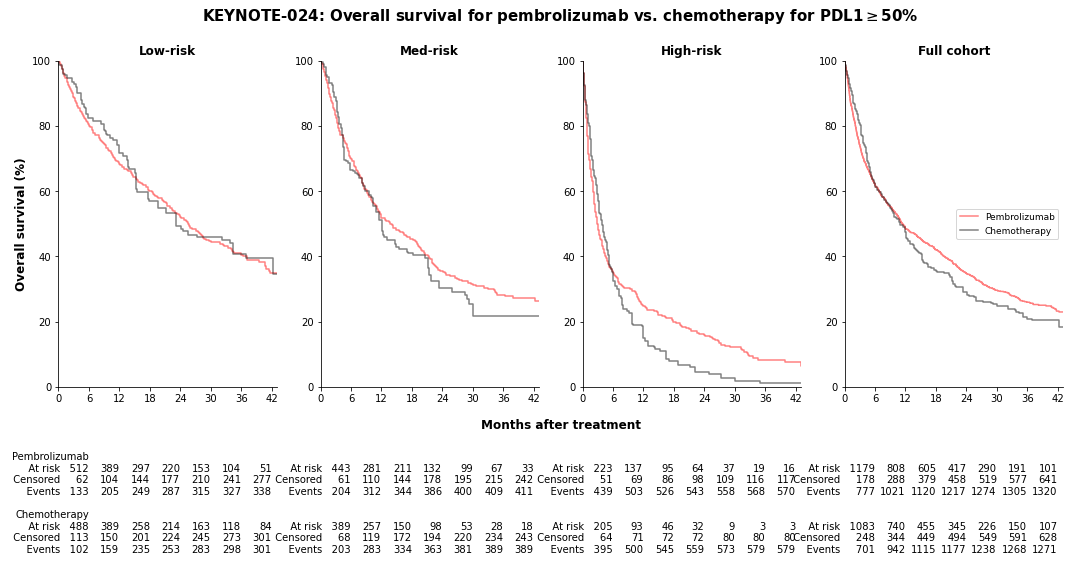

In [172]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_024_iptw.timeline, kmf_low_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_low_pembro_024_iptw.confidence_interval_.index, np.array(kmf_low_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_low_pembro_024_iptw.confidence_interval_.index, np.array(kmf_low_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_low_pembro_024_iptw.timeline, np.array(kmf_low_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_plat_024_iptw.timeline, kmf_low_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_low_plat_024_iptw.confidence_interval_.index, np.array(kmf_low_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_low_plat_024_iptw.confidence_interval_.index, np.array(kmf_low_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_low_plat_024_iptw.timeline, np.array(kmf_low_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_pembro_024_iptw, kmf_low_plat_024_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = ['Pembrolizumab', 'Chemotherapy'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_024_iptw.timeline, kmf_med_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_med_pembro_024_iptw.confidence_interval_.index, np.array(kmf_med_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_med_pembro_024_iptw.confidence_interval_.index, np.array(kmf_med_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_med_pembro_024_iptw.timeline, np.array(kmf_med_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_plat_024_iptw.timeline, kmf_med_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_med_plat_024_iptw.confidence_interval_.index, np.array(kmf_med_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_med_plat_024_iptw.confidence_interval_.index, np.array(kmf_med_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_med_plat_024_iptw.timeline, np.array(kmf_med_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_pembro_024_iptw, kmf_med_plat_024_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_024_iptw.timeline, kmf_high_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_high_pembro_024_iptw.confidence_interval_.index, np.array(kmf_high_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_high_pembro_024_iptw.confidence_interval_.index, np.array(kmf_high_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_high_pembro_024_iptw.timeline, np.array(kmf_high_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_plat_024_iptw.timeline, kmf_high_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_high_plat_024_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_high_plat_024_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_high_plat_024_iptw.timeline[:-1], (np.array(kmf_high_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], (np.array(kmf_high_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_pembro_024_iptw, kmf_high_plat_024_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_024_iptw.timeline, kmf_all_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')
#plt.step(kmf_all_pembro_024_iptw.confidence_interval_.index, np.array(kmf_all_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_all_pembro_024_iptw.confidence_interval_.index, np.array(kmf_all_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_all_pembro_024_iptw.timeline, np.array(kmf_all_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_plat_024_iptw.timeline, kmf_all_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')
#plt.step(kmf_all_plat_024_iptw.confidence_interval_.index, np.array(kmf_all_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_all_plat_024_iptw.confidence_interval_.index, np.array(kmf_all_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_all_plat_024_iptw.timeline, np.array(kmf_all_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_pembro_024_iptw, kmf_all_plat_024_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-024: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$50%', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [173]:
pembro_024_12_os = psurv_t(kmf_low_pembro_024_iptw, 
                           kmf_med_pembro_024_iptw,
                           kmf_high_pembro_024_iptw,
                           12)

plat_024_12_os = psurv_t(kmf_low_plat_024_iptw,
                         kmf_med_plat_024_iptw,
                         kmf_high_plat_024_iptw,
                         12)

pembro_024_24_os = psurv_t(kmf_low_pembro_024_iptw, 
                           kmf_med_pembro_024_iptw,
                           kmf_high_pembro_024_iptw,
                           24)

plat_024_24_os = psurv_t(kmf_low_plat_024_iptw,
                         kmf_med_plat_024_iptw,
                         kmf_high_plat_024_iptw,
                         24)

pembro_024_median_os = mos(kmf_low_pembro_024_iptw,
                           kmf_med_pembro_024_iptw,
                           kmf_high_pembro_024_iptw,
                           kmf_all_pembro_024_iptw)

plat_024_median_os = mos(kmf_low_plat_024_iptw,
                         kmf_med_plat_024_iptw,
                         kmf_high_plat_024_iptw,
                         kmf_all_plat_024_iptw)

In [174]:
print('All, pembro: ',truncate(pembro_024_median_os[3], 3))
print('All, platinum: ',truncate(plat_024_median_os[3], 3))

print('Low, pembro: ',truncate(pembro_024_median_os[0], 3))
print('Low, platinum: ',truncate(plat_024_median_os[0], 3))

print('Med, pembro: ',truncate(pembro_024_median_os[1], 3))
print('Med, platinum: ',truncate(plat_024_median_os[1], 3))

print('High, pembro: ',truncate(pembro_024_median_os[2], 3))
print('High, platinum: ',truncate(plat_024_median_os[2], 3))

All, pembro:  11.433
All, platinum:  11.133
Low, pembro:  25.666
Low, platinum:  24.133
Med, pembro:  13.933
Med, platinum:  12.133
High, pembro:  3.0
High, platinum:  3.966


In [175]:
pembro_024_low_12_ci = psurv_ci(kmf_low_pembro_024_iptw, 12)
pembro_024_med_12_ci = psurv_ci(kmf_med_pembro_024_iptw, 12)
pembro_024_high_12_ci = psurv_ci(kmf_high_pembro_024_iptw, 12)

y_error_pembro_024_12 = y_error(pembro_024_low_12_ci,
                                pembro_024_med_12_ci,
                                pembro_024_high_12_ci,
                                pembro_024_12_os)

In [176]:
plat_024_low_12_ci = psurv_ci(kmf_low_plat_024_iptw, 12)
plat_024_med_12_ci = psurv_ci(kmf_med_plat_024_iptw, 12)
plat_024_high_12_ci = psurv_ci(kmf_high_plat_024_iptw, 12)

y_error_plat_024_12 = y_error(plat_024_low_12_ci,
                              plat_024_med_12_ci,
                              plat_024_high_12_ci,
                              plat_024_12_os)

In [177]:
pembro_024_low_24_ci = psurv_ci(kmf_low_pembro_024_iptw, 24)
pembro_024_med_24_ci = psurv_ci(kmf_med_pembro_024_iptw, 24)
pembro_024_high_24_ci = psurv_ci(kmf_high_pembro_024_iptw, 24)

y_error_pembro_024_24 = y_error(pembro_024_low_24_ci,
                                pembro_024_med_24_ci,
                                pembro_024_high_24_ci,
                                pembro_024_24_os)

In [178]:
plat_024_low_24_ci = psurv_ci(kmf_low_plat_024_iptw, 24)
plat_024_med_24_ci = psurv_ci(kmf_med_plat_024_iptw, 24)
plat_024_high_24_ci = psurv_ci(kmf_high_plat_024_iptw, 24)

y_error_plat_024_24 = y_error(plat_024_low_24_ci,
                              plat_024_med_24_ci,
                              plat_024_high_24_ci,
                              plat_024_24_os)

In [179]:
pembro_024_low_mos_ci = mos_ci(kmf_low_pembro_024_iptw)
pembro_024_med_mos_ci = mos_ci(kmf_med_pembro_024_iptw)
pembro_024_high_mos_ci = mos_ci(kmf_high_pembro_024_iptw)

y_error_pembro_024_mos = y_error(pembro_024_low_mos_ci,
                                 pembro_024_med_mos_ci,
                                 pembro_024_high_mos_ci,
                                 pembro_024_median_os)

In [180]:
plat_024_low_mos_ci = mos_ci(kmf_low_plat_024_iptw)
plat_024_med_mos_ci = mos_ci(kmf_med_plat_024_iptw)
plat_024_high_mos_ci = mos_ci(kmf_high_plat_024_iptw)

y_error_plat_024_mos = y_error(plat_024_low_mos_ci,
                               plat_024_med_mos_ci,
                               plat_024_high_mos_ci,
                               plat_024_median_os)

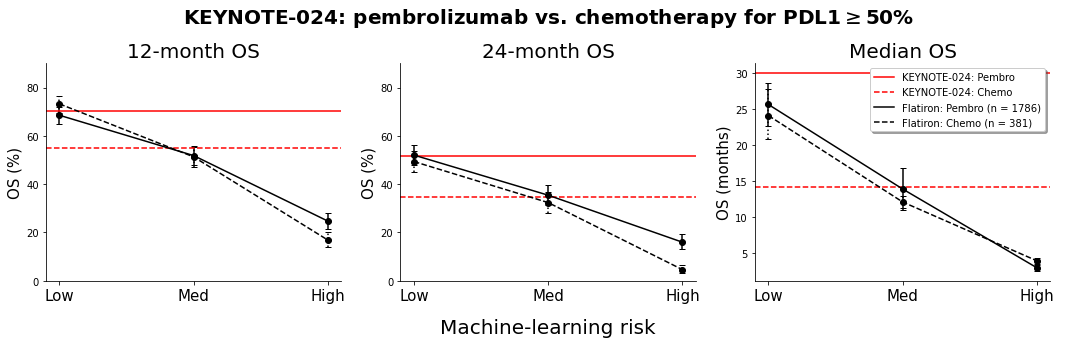

In [181]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, pembro_024_12_os, yerr = y_error_pembro_024_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 70.3, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, plat_024_12_os, yerr = y_error_plat_024_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 54.8, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('12-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, pembro_024_24_os, yerr = y_error_pembro_024_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 51.5, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, plat_024_24_os, yerr = y_error_plat_024_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 34.5, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, pembro_024_median_os[0:3], yerr = y_error_pembro_024_mos, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 30.0, color = 'red', linestyle = 'solid')

eb3 = plt.errorbar(ml_risk, plat_024_median_os[0:3], yerr = y_error_plat_024_mos, marker = 'o', linestyle = '--', color = 'black', capsize = 3)
eb3[-1][0].set_linestyle(':')
plt.axhline(y = 14.2, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title(r'KEYNOTE-024: pembrolizumab vs. chemotherapy for PDL1$\geq$50%', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'KEYNOTE-024: Pembro'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'KEYNOTE-024: Chemo'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Pembro (n = {})'.format(key_024.query('pembro == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Chemo (n = {})'.format(key_024.query('pembro == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'upper right', prop = {'size': 10})

#plt.savefig('key024_summary_rc.png', bbox_inches = 'tight')

plt.show()

### KEYNOTE-189: First-line pembrolizumab plus chemotherapy vs. chemotherapy

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line pemobrolizumab plus platinum-based chemotherapy (carboplatin + pemetrexed or cisplatin + pemetrexed) or platinum-based chemotherapy
* Histology nonsquamous 
* EGFR and ALK negative

#### Pembrolizumab + chemotherapy 

In [182]:
df_full = pd.read_csv('df_risk_crude.csv', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [183]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [184]:
line_therapy[line_therapy['LineName'].str.contains('Pemetrexed')].LineName.value_counts().head(10)

Carboplatin,Pemetrexed                              6700
Carboplatin,Pembrolizumab,Pemetrexed                5113
Pemetrexed                                          4711
Bevacizumab,Carboplatin,Pemetrexed                  3459
Bevacizumab,Pemetrexed                              1569
Pembrolizumab,Pemetrexed                            1554
Cisplatin,Pemetrexed                                 811
Bevacizumab,Cisplatin,Pemetrexed                     174
Abiraterone,Carboplatin,Pembrolizumab,Pemetrexed     100
Bevacizumab-Awwb,Carboplatin,Pemetrexed               82
Name: LineName, dtype: int64

In [185]:
pembro_plat = [
    'Carboplatin,Pembrolizumab,Pemetrexed',
    'Cisplatin,Pembrolizumab,Pemetrexed'
]

key189_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full['PatientID'])]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == @pembro_plat')
    [['PatientID', 'StartDate']]
)

In [186]:
key189_pembro.loc[:, 'pembro'] = 1

In [187]:
row_ID(key189_pembro)

(4302, 4302)

In [188]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_189 = (
    line_therapy[line_therapy['PatientID'].isin(key189_pembro.PatientID)])

In [189]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [190]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_189_xcross = (
    line_therapy_pembro_189[line_therapy_pembro_189['LineName'].str.contains('|'.join(targeted))].PatientID)

In [191]:
# Select patients who don't receive targeted therapy in future lines.
key189_pembro = key189_pembro[~key189_pembro['PatientID'].isin(pembro_189_xcross)]

In [192]:
row_ID(key189_pembro)

(4135, 4135)

#### Platinum-based chemotherapy

In [193]:
plat_chemo = [
    'Carboplatin,Pemetrexed',
    'Cisplatin,Pemetrexed'
]

key189_plat = (
    line_therapy[line_therapy['PatientID'].isin(df_full['PatientID'])]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == @plat_chemo')
    [['PatientID', 'StartDate']]
)

In [194]:
key189_plat.loc[:, 'pembro'] = 0

In [195]:
row_ID(key189_plat)

(6101, 6101)

In [196]:
# Dataframe of all therapies received for those receiving first line platinum regimen approved by KEY-042.  
line_therapy_plat_189 = (
    line_therapy[line_therapy['PatientID'].isin(key189_plat.PatientID)])

In [197]:
# Patients receiving platinum therapy who later recieve immunotherapy or targeted therapy. 
plat_189_xcross = (
    line_therapy_plat_189[line_therapy_plat_189['LineName'].str.contains('|'.join(targeted))].PatientID)

In [198]:
# Select patients who don't receive targeted therapy, immunotherapy, or clinical study drug in future lines.
key189_plat = key189_plat[~key189_plat['PatientID'].isin(plat_189_xcross)]

In [199]:
row_ID(key189_plat)

(5543, 5543)

In [200]:
key_189 = pd.concat([key189_pembro, key189_plat])

In [201]:
row_ID(key_189)

(9678, 9678)

In [202]:
key_189 = pd.merge(key_189, df_full, on = 'PatientID', how = 'inner')

In [203]:
row_ID(key_189)

(9678, 9678)

In [204]:
key_189['StartDate'] = pd.to_datetime(key_189['StartDate'])

#### Time from treatment to death or censor

In [205]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [206]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [207]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [208]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [209]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [210]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [211]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [212]:
key_189 = pd.merge(key_189, mortality, on = 'PatientID')

In [213]:
len(key_189)

9678

In [214]:
conditions = [
    (key_189['death_status'] == 1),
    (key_189['death_status'] == 0)]

choices = [
    (key_189['death_date'] - key_189['StartDate']).dt.days,
    (key_189['last_activity'] - key_189['StartDate']).dt.days]

key_189.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [215]:
key_189 = key_189.query('timerisk_treatment >= 0')

#### Patient count

In [216]:
key_189 = (
    key_189
    .query('stage == "IV"')
    .query('Histology == "Non-squamous cell carcinoma"')
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [217]:
low_cutoff_189 = key_189.risk_score.quantile(1/3)

In [218]:
high_cutoff_189 = key_189.risk_score.quantile(2/3)

In [219]:
print('Pembro + chemo total:',  key_189.query('pembro == 1').shape[0])
print('High risk:', key_189.query('pembro == 1').query('risk_score >= @high_cutoff_189').shape[0])
print('Med risk:', key_189.query('pembro == 1').query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189').shape[0])
print('Low risk:', key_189.query('pembro == 1').query('risk_score <= @low_cutoff_189').shape[0])

Pembro + chemo total: 3191
High risk: 993
Med risk: 1041
Low risk: 1157


In [220]:
print('Platinum total:',  key_189.query('pembro == 0').shape[0])
print('High risk:', key_189.query('pembro == 0').query('risk_score >= @high_cutoff_189').shape[0])
print('Med risk:', key_189.query('pembro == 0').query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189').shape[0])
print('Low risk:', key_189.query('pembro == 0').query('risk_score <= @low_cutoff_189').shape[0])

Platinum total: 3762
High risk: 1325
Med risk: 1276
Low risk: 1161


In [221]:
risk_cutoff_lung.loc['keynote_189'] = [low_cutoff_189, high_cutoff_189]

#### Survival curves w/out adjusting for confounders

In [222]:
key_189 = key_189.set_index('PatientID')

In [223]:
key189_low_pembro = (
    key_189
    .query('pembro == 1')
    .query('risk_score <= @low_cutoff_189')
    .index)

key189_low_plat = (
    key_189
    .query('pembro == 0')
    .query('risk_score <= @low_cutoff_189')
    .index)

key189_med_pembro = (
    key_189
    .query('pembro == 1')
    .query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189')
    .index)

key189_med_plat = (
    key_189
    .query('pembro == 0')
    .query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189')
    .index)

key189_high_pembro = (
    key_189
    .query('pembro == 1')
    .query('risk_score >= @high_cutoff_189')
    .index)

key189_high_plat = (
    key_189
    .query('pembro == 0')
    .query('risk_score >= @high_cutoff_189')
    .index)

key189_all_pembro = (
    key_189
    .query('pembro == 1')
    .index)

key189_all_plat = (
    key_189
    .query('pembro == 0')
    .index)

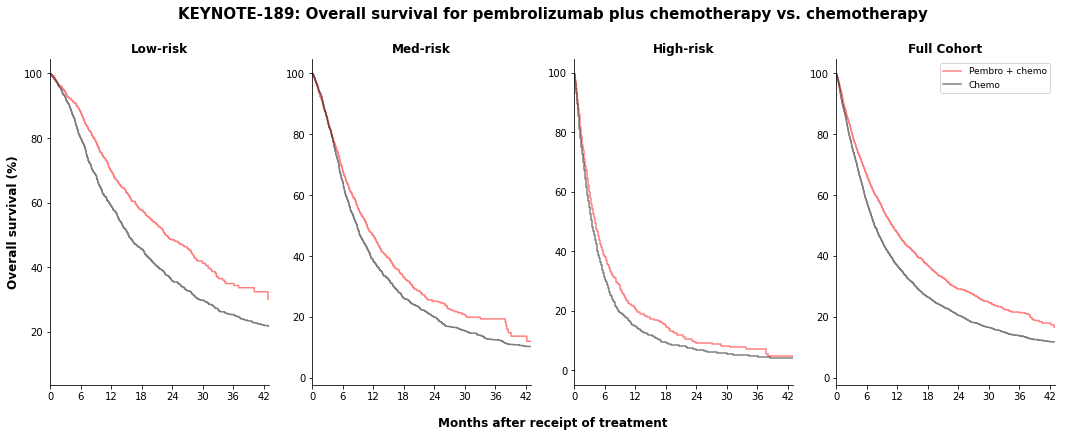

In [224]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low-risk group. 
plt.subplot(1, 4, 1)

time_low_pembro_189, survival_prob_low_pembro_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_low_pembro]['death_status']),
                                                                           np.array(key_189.loc[key189_low_pembro]['timerisk_treatment']))

time_low_plat_189, survival_prob_low_plat_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_low_plat]['death_status']),
                                                                       np.array(key_189.loc[key189_low_plat]['timerisk_treatment']))

plt.step(time_low_pembro_189/30, survival_prob_low_pembro_189*100, color = 'red', alpha = 0.5)
plt.step(time_low_plat_189/30, survival_prob_low_plat_189*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for fairly low-risk group. 
plt.subplot(1, 4, 2)

time_med_pembro_189, survival_prob_med_pembro_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_med_pembro]['death_status']),
                                                                           np.array(key_189.loc[key189_med_pembro]['timerisk_treatment']))

time_med_plat_189, survival_prob_med_plat_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_med_plat]['death_status']),
                                                                       np.array(key_189.loc[key189_med_plat]['timerisk_treatment']))

plt.step(time_med_pembro_189/30, survival_prob_med_pembro_189*100, color = 'red', alpha = 0.5)
plt.step(time_med_plat_189/30, survival_prob_med_plat_189*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high-risk group. 
plt.subplot(1, 4, 3)

time_high_pembro_189, survival_prob_high_pembro_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_high_pembro]['death_status']),
                                                                             np.array(key_189.loc[key189_high_pembro]['timerisk_treatment']))

time_high_plat_189, survival_prob_high_plat_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_high_plat]['death_status']),
                                                                         np.array(key_189.loc[key189_high_plat]['timerisk_treatment']))

plt.step(time_high_pembro_189/30, survival_prob_high_pembro_189*100, color = 'red', alpha = 0.5)
plt.step(time_high_plat_189/30, survival_prob_high_plat_189*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all. 
plt.subplot(1, 4, 4)

time_all_pembro_189, survival_prob_all_pembro_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_all_pembro]['death_status']),
                                                                           np.array(key_189.loc[key189_all_pembro]['timerisk_treatment']))

time_all_plat_189, survival_prob_all_plat_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_all_plat]['death_status']),
                                                                       np.array(key_189.loc[key189_all_plat]['timerisk_treatment']))

plt.step(time_all_pembro_189/30, survival_prob_all_pembro_189*100, color = 'red', alpha = 0.5, label = 'Pembro + chemo')
plt.step(time_all_plat_189/30, survival_prob_all_plat_189*100, color = 'black', alpha = 0.5, label = 'Chemo')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)

plt.title('Full Cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after receipt of treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('KEYNOTE-189: Overall survival for pembrolizumab plus chemotherapy vs. chemotherapy', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival curves with confounder adjustment via IPTW

In [225]:
key_189_iptw = key_189.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'adv_year',
                                       'steroid_diag',
                                       'opioid_PO_diag',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'pdl1_n',
                                       'risk_score'])

In [226]:
key_189_iptw.dtypes

death_status             bool
timerisk_treatment    float64
pembro                  int64
age                     int64
gender                 object
race                   object
PracticeType           object
adv_year                int64
steroid_diag          float64
opioid_PO_diag        float64
commercial            float64
medicare              float64
medicaid              float64
pdl1_n                 object
risk_score            float64
dtype: object

In [227]:
to_be_categorical = list(key_189_iptw.select_dtypes(include = ['object']).columns)

In [228]:
to_be_categorical

['gender', 'race', 'PracticeType', 'pdl1_n']

In [229]:
to_be_categorical.append('adv_year')

In [230]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_189_iptw[x] = key_189_iptw[x].astype('category')

In [231]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [232]:
# List of categorical features.
categorical_features = list(key_189_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [233]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [234]:
key_189_iptw_low = (
    key_189_iptw
    .query('risk_score <= @low_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_med = (
    key_189_iptw
    .query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_high = (
    key_189_iptw
    .query('risk_score >= @high_cutoff_189')
    .drop(columns = ['risk_score']))

In [235]:
key_189_low_x = preprocessor.fit_transform(key_189_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'adv_year',
                                                                            'steroid_diag',
                                                                            'opioid_PO_diag',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid', 
                                                                            'pdl1_n']))

key_189_med_x = preprocessor.fit_transform(key_189_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'adv_year',
                                                                            'steroid_diag',
                                                                            'opioid_PO_diag',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'pdl1_n']))

key_189_high_x = preprocessor.fit_transform(key_189_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'adv_year',
                                                                              'steroid_diag',
                                                                              'opioid_PO_diag',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'pdl1_n']))

In [236]:
lr_189_low = LogisticRegression(max_iter = 1000)
lr_189_low.fit(key_189_low_x, key_189_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [237]:
lr_189_med = LogisticRegression(max_iter = 1000)
lr_189_med.fit(key_189_med_x, key_189_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [238]:
lr_189_high = LogisticRegression(max_iter = 1000)
lr_189_high.fit(key_189_high_x, key_189_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [239]:
pred_low = lr_189_low.predict_proba(key_189_low_x)
pred_med = lr_189_med.predict_proba(key_189_med_x)
pred_high = lr_189_high.predict_proba(key_189_high_x)

In [240]:
key_189_iptw_low['ps'] = pred_low[:, 1]
key_189_iptw_med['ps'] = pred_med[:, 1]
key_189_iptw_high['ps'] = pred_high[:, 1]

In [241]:
key_189_iptw_low['weight'] = (
    np.where(key_189_iptw_low['pembro'] == 1, 1/key_189_iptw_low['ps'], 1/(1 - key_189_iptw_low['ps'])))

key_189_iptw_med['weight'] = (
    np.where(key_189_iptw_med['pembro'] == 1, 1/key_189_iptw_med['ps'], 1/(1 - key_189_iptw_med['ps'])))

key_189_iptw_high['weight'] = (
    np.where(key_189_iptw_high['pembro'] == 1, 1/key_189_iptw_high['ps'], 1/(1 - key_189_iptw_high['ps'])))

In [242]:
key_189_iptw_all = pd.concat([key_189_iptw_low, key_189_iptw_med, key_189_iptw_high])

In [243]:
# Low KM curves
kmf_low_pembro_189_iptw = KaplanMeierFitter()
kmf_low_plat_189_iptw = KaplanMeierFitter()

kmf_low_pembro_189_iptw.fit(
    key_189_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_low.query('pembro == 1').death_status,
    weights = key_189_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_189_iptw.fit(
    key_189_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_low.query('pembro == 0').death_status,
    weights = key_189_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_189_iptw = KaplanMeierFitter()
kmf_med_plat_189_iptw = KaplanMeierFitter()

kmf_med_pembro_189_iptw.fit(
    key_189_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_med.query('pembro == 1').death_status,
    weights = key_189_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_189_iptw.fit(
    key_189_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_med.query('pembro == 0').death_status,
    weights = key_189_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_189_iptw = KaplanMeierFitter()
kmf_high_plat_189_iptw = KaplanMeierFitter()

kmf_high_pembro_189_iptw.fit(
    key_189_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_high.query('pembro == 1').death_status,
    weights = key_189_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_189_iptw.fit(
    key_189_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_high.query('pembro == 0').death_status,
    weights = key_189_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_189_iptw = KaplanMeierFitter()
kmf_all_plat_189_iptw = KaplanMeierFitter()

kmf_all_pembro_189_iptw.fit(
    key_189_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_all.query('pembro == 1').death_status,
    weights = key_189_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_189_iptw.fit(
    key_189_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_all.query('pembro == 0').death_status,
    weights = key_189_iptw_all.query('pembro == 0')['weight'])

/Applications/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 6734.56 total observations, 1806.19 right-censored observations>

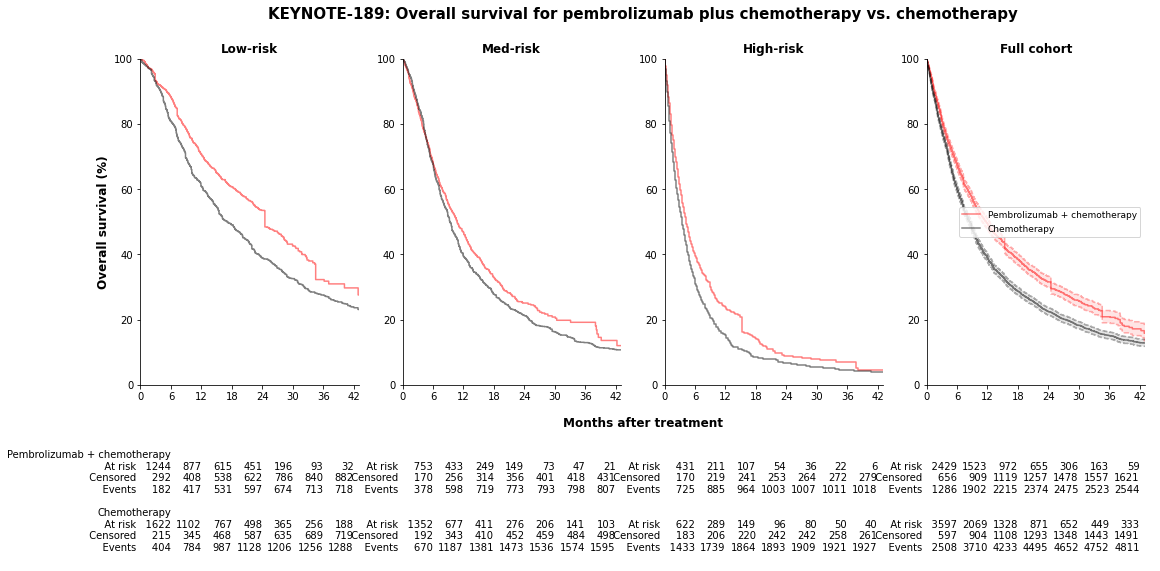

In [244]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_189_iptw.timeline, kmf_low_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_low_pembro_189_iptw.confidence_interval_.index, np.array(kmf_low_pembro_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_low_pembro_189_iptw.confidence_interval_.index, np.array(kmf_low_pembro_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_low_pembro_189_iptw.timeline, np.array(kmf_low_pembro_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_pembro_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_plat_189_iptw.timeline, kmf_low_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_low_plat_189_iptw.confidence_interval_.index, np.array(kmf_low_plat_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_low_plat_189_iptw.confidence_interval_.index, np.array(kmf_low_plat_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_low_plat_189_iptw.timeline, np.array(kmf_low_plat_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_plat_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_pembro_189_iptw, kmf_low_plat_189_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = ['Pembrolizumab + chemotherapy', 'Chemotherapy'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_189_iptw.timeline, kmf_med_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_med_pembro_189_iptw.confidence_interval_.index, np.array(kmf_med_pembro_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_med_pembro_189_iptw.confidence_interval_.index, np.array(kmf_med_pembro_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_med_pembro_189_iptw.timeline, np.array(kmf_med_pembro_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_pembro_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_plat_189_iptw.timeline, kmf_med_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_med_plat_189_iptw.confidence_interval_.index, np.array(kmf_med_plat_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_med_plat_189_iptw.confidence_interval_.index, np.array(kmf_med_plat_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_med_plat_189_iptw.timeline, np.array(kmf_med_plat_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_plat_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_pembro_189_iptw, kmf_med_plat_189_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_189_iptw.timeline, kmf_high_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_high_pembro_024_iptw.confidence_interval_.index, np.array(kmf_high_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_high_pembro_024_iptw.confidence_interval_.index, np.array(kmf_high_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_high_pembro_024_iptw.timeline, np.array(kmf_high_pembro_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_pembro_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_plat_189_iptw.timeline, kmf_high_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_high_plat_024_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_high_plat_024_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_high_plat_024_iptw.timeline[:-1], (np.array(kmf_high_plat_024_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], (np.array(kmf_high_plat_024_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_pembro_189_iptw, kmf_high_plat_189_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_189_iptw.timeline, kmf_all_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab + chemotherapy')
plt.step(kmf_all_pembro_189_iptw.confidence_interval_.index, np.array(kmf_all_pembro_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.step(kmf_all_pembro_189_iptw.confidence_interval_.index, np.array(kmf_all_pembro_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
plt.fill_between(kmf_all_pembro_189_iptw.timeline, np.array(kmf_all_pembro_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_pembro_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_plat_189_iptw.timeline, kmf_all_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')
plt.step(kmf_all_plat_189_iptw.confidence_interval_.index, np.array(kmf_all_plat_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.step(kmf_all_plat_189_iptw.confidence_interval_.index, np.array(kmf_all_plat_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
plt.fill_between(kmf_all_plat_189_iptw.timeline, np.array(kmf_all_plat_189_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_plat_189_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_pembro_189_iptw, kmf_all_plat_189_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('KEYNOTE-189: Overall survival for pembrolizumab plus chemotherapy vs. chemotherapy', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [245]:
pembro_189_12_os = psurv_t(kmf_low_pembro_189_iptw, 
                           kmf_med_pembro_189_iptw,
                           kmf_high_pembro_189_iptw,
                           12)

plat_189_12_os = psurv_t(kmf_low_plat_189_iptw,
                         kmf_med_plat_189_iptw,
                         kmf_high_plat_189_iptw,
                         12)

pembro_189_24_os = psurv_t(kmf_low_pembro_189_iptw, 
                           kmf_med_pembro_189_iptw,
                           kmf_high_pembro_189_iptw,
                           24)

plat_189_24_os = psurv_t(kmf_low_plat_189_iptw,
                         kmf_med_plat_189_iptw,
                         kmf_high_plat_189_iptw,
                         24)

pembro_189_median_os = mos(kmf_low_pembro_189_iptw,
                           kmf_med_pembro_189_iptw,
                           kmf_high_pembro_189_iptw,
                           kmf_all_pembro_189_iptw)

plat_189_median_os = mos(kmf_low_plat_189_iptw,
                         kmf_med_plat_189_iptw,
                         kmf_high_plat_189_iptw,
                         kmf_all_plat_189_iptw)

In [246]:
print('All, pembro: ',truncate(pembro_189_median_os[3], 3))
print('All, platinum: ',truncate(plat_189_median_os[3], 3))

print('Low, pembro: ',truncate(pembro_189_median_os[0], 3))
print('Low, platinum: ',truncate(plat_189_median_os[0], 3))

print('Med, pembro: ',truncate(pembro_189_median_os[1], 3))
print('Med, platinum: ',truncate(plat_189_median_os[1], 3))

print('High, pembro: ',truncate(pembro_189_median_os[2], 3))
print('High, platinum: ',truncate(plat_189_median_os[2], 3))

All, pembro:  11.8
All, platinum:  8.5
Low, pembro:  24.6
Low, platinum:  17.066
Med, pembro:  10.8
Med, platinum:  9.333
High, pembro:  4.233
High, platinum:  3.5


In [247]:
pembro_189_low_12_ci = psurv_ci(kmf_low_pembro_189_iptw, 12)
pembro_189_med_12_ci = psurv_ci(kmf_med_pembro_189_iptw, 12)
pembro_189_high_12_ci = psurv_ci(kmf_high_pembro_189_iptw, 12)

y_error_pembro_189_12 = y_error(pembro_189_low_12_ci,
                                pembro_189_med_12_ci,
                                pembro_189_high_12_ci,
                                pembro_189_12_os)

In [248]:
plat_189_low_12_ci = psurv_ci(kmf_low_plat_189_iptw, 12)
plat_189_med_12_ci = psurv_ci(kmf_med_plat_189_iptw, 12)
plat_189_high_12_ci = psurv_ci(kmf_high_plat_189_iptw, 12)

y_error_plat_189_12 = y_error(plat_189_low_12_ci,
                              plat_189_med_12_ci,
                              plat_189_high_12_ci,
                              plat_189_12_os)

In [249]:
pembro_189_low_24_ci = psurv_ci(kmf_low_pembro_189_iptw, 24)
pembro_189_med_24_ci = psurv_ci(kmf_med_pembro_189_iptw, 24)
pembro_189_high_24_ci = psurv_ci(kmf_high_pembro_189_iptw, 24)

y_error_pembro_189_24 = y_error(pembro_189_low_24_ci,
                                pembro_189_med_24_ci,
                                pembro_189_high_24_ci,
                                pembro_189_24_os)

In [250]:
plat_189_low_24_ci = psurv_ci(kmf_low_plat_189_iptw, 24)
plat_189_med_24_ci = psurv_ci(kmf_med_plat_189_iptw, 24)
plat_189_high_24_ci = psurv_ci(kmf_high_plat_189_iptw, 24)

y_error_plat_189_24 = y_error(plat_189_low_24_ci,
                              plat_189_med_24_ci,
                              plat_189_high_24_ci,
                              plat_189_24_os)

In [251]:
pembro_189_low_mos_ci = mos_ci(kmf_low_pembro_189_iptw)
pembro_189_med_mos_ci = mos_ci(kmf_med_pembro_189_iptw)
pembro_189_high_mos_ci = mos_ci(kmf_high_pembro_189_iptw)

y_error_pembro_189_mos = y_error(pembro_189_low_mos_ci,
                                 pembro_189_med_mos_ci,
                                 pembro_189_high_mos_ci,
                                 pembro_189_median_os)

In [252]:
plat_189_low_mos_ci = mos_ci(kmf_low_plat_189_iptw)
plat_189_med_mos_ci = mos_ci(kmf_med_plat_189_iptw)
plat_189_high_mos_ci = mos_ci(kmf_high_plat_189_iptw)

y_error_plat_189_mos = y_error(plat_189_low_mos_ci, 
                               plat_189_med_mos_ci, 
                               plat_189_high_mos_ci, 
                               plat_189_median_os)

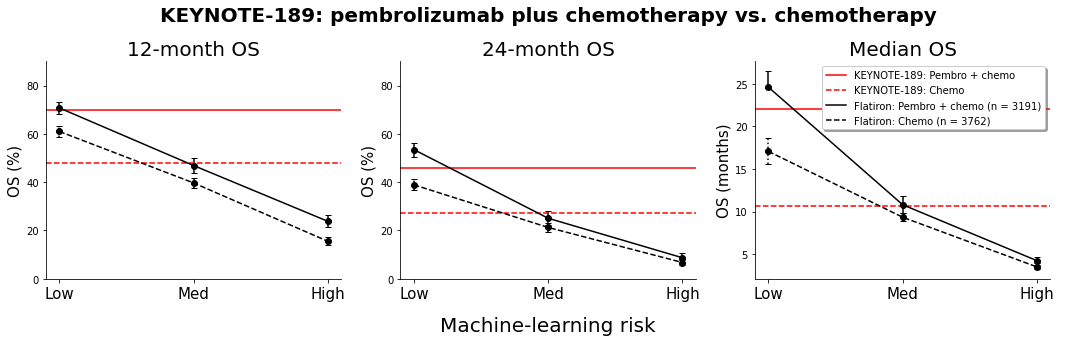

In [253]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, pembro_189_12_os, yerr = y_error_pembro_189_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 69.8, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, plat_189_12_os, yerr = y_error_plat_189_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 48.0, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('12-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, pembro_189_24_os, yerr = y_error_pembro_189_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 45.7, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, plat_189_24_os, yerr = y_error_plat_189_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 27.3, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, pembro_189_median_os[0:3], yerr = y_error_pembro_189_mos, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 22, color = 'red', linestyle = 'solid')

eb3 = plt.errorbar(ml_risk, plat_189_median_os[0:3], yerr = y_error_plat_189_mos, marker = 'o', linestyle = '--', color = 'black', capsize = 3)
eb3[-1][0].set_linestyle(':')
plt.axhline(y = 10.6, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('KEYNOTE-189: pembrolizumab plus chemotherapy vs. chemotherapy', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'KEYNOTE-189: Pembro + chemo'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'KEYNOTE-189: Chemo'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Pembro + chemo (n = {})'.format(key_189.query('pembro == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Chemo (n = {})'.format(key_189.query('pembro == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'upper right', prop = {'size': 10})

#plt.savefig('key189_summary_rc.png', bbox_inches = 'tight')

plt.show()

### CHECKMATE-078: Second-line nivolumab vs. docetaxel

**INCLUSION CRITERIA**
* Advanced or metastatic NSCLC 
* Progressed on first line platinum-based chemotherapy 
* Received second line nivolumab or docetaxel
* Prior treatments with docetaxel or immunotherapy contraindicated
* EGFR and ALK negative 

#### Nivolumab 

In [254]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [255]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [256]:
line_therapy_fl = (
    line_therapy[line_therapy.PatientID.isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [257]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [258]:
immunotherapy = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [259]:
fl_plat = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('Carboplatin|Cisplatin')
     & ~line_therapy_fl['LineName'].str.contains('Docetaxel')
     & ~line_therapy_fl['LineName'].str.contains('|'.join(targeted))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(immunotherapy))]
    .PatientID
)

In [260]:
checkmate_nivo = (
    line_therapy[line_therapy.PatientID.isin(fl_plat)]
    .query('LineNumber == 2')
    .query('LineName == "Nivolumab"')
    [['PatientID', 'StartDate']]
)

In [261]:
checkmate_nivo.loc[:, 'nivo'] = 1

In [262]:
row_ID(checkmate_nivo)

(3397, 3397)

#### Docetaxel

In [263]:
checkmate_dotx = (
    line_therapy[line_therapy.PatientID.isin(fl_plat)]
    .query('LineNumber == 2')
    .query('LineName == "Docetaxel"')
    [['PatientID', 'StartDate']]
)

In [264]:
checkmate_dotx.loc[:, 'nivo'] = 0

In [265]:
row_ID(checkmate_dotx)

(745, 745)

In [266]:
checkmate = pd.concat([checkmate_nivo, checkmate_dotx])

In [267]:
row_ID(checkmate)

(4142, 4142)

In [268]:
checkmate = pd.merge(checkmate, df_full, on = 'PatientID', how = 'inner')

In [269]:
row_ID(checkmate)

(4142, 4142)

In [270]:
checkmate['StartDate'] = pd.to_datetime(checkmate['StartDate'])

#### Time from treatment to death or censor 

In [271]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [272]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [273]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [274]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [275]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [276]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [277]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [278]:
checkmate = pd.merge(checkmate, mortality, on = 'PatientID')

In [279]:
row_ID(checkmate)

(4142, 4142)

In [280]:
conditions = [
    (checkmate['death_status'] == 1),
    (checkmate['death_status'] == 0)]

choices = [
    (checkmate['death_date'] - checkmate['StartDate']).dt.days,
    (checkmate['last_activity'] - checkmate['StartDate']).dt.days]

checkmate.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [281]:
checkmate = checkmate.query('timerisk_treatment >= 0')

#### Patient count 

In [282]:
checkmate = (
    checkmate
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [283]:
low_cutoff_078 = checkmate.risk_score.quantile(1/3)

In [284]:
high_cutoff_078 = checkmate.risk_score.quantile(2/3)

In [285]:
print('Nivolumab total:',  checkmate.query('nivo == 1').shape[0])
print('High risk:', checkmate.query('nivo == 1').query('risk_score >= @high_cutoff_078').shape[0])
print('Med risk:', checkmate.query('nivo == 1').query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078').shape[0])
print('Low risk:', checkmate.query('nivo == 1').query('risk_score <= @low_cutoff_078').shape[0])

Nivolumab total: 3339
High risk: 1114
Med risk: 1111
Low risk: 1114


In [286]:
print('Docetaxel total:',  checkmate.query('nivo == 0').shape[0])
print('High risk:', checkmate.query('nivo == 0').query('risk_score >= @high_cutoff_078').shape[0])
print('Med risk:', checkmate.query('nivo == 0').query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078').shape[0])
print('Low risk:', checkmate.query('nivo == 0').query('risk_score <= @low_cutoff_078').shape[0])

Docetaxel total: 734
High risk: 244
Med risk: 246
Low risk: 244


In [287]:
risk_cutoff_lung.loc['checkmate_078'] = [low_cutoff_078, high_cutoff_078]

#### Survival curves w/out adjusting for confounders

In [288]:
checkmate = checkmate.set_index('PatientID')

In [289]:
check_low_nivo = (
    checkmate
    .query('nivo == 1')
    .query('risk_score <= @low_cutoff_078')
    .index)

check_low_dotx = (
    checkmate
    .query('nivo == 0')
    .query('risk_score <= @low_cutoff_078')
    .index)

check_med_nivo = (
    checkmate
    .query('nivo == 1')
    .query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078')
    .index)

check_med_dotx = (
    checkmate
    .query('nivo == 0')
    .query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078')
    .index)

check_high_nivo = (
    checkmate
    .query('nivo == 1')
    .query('risk_score >= @high_cutoff_078')
    .index)

check_high_dotx = (
    checkmate
    .query('nivo == 0')
    .query('risk_score >= @high_cutoff_078')
    .index)

check_all_nivo = (
    checkmate
    .query('nivo == 1')
    .index)

check_all_dotx = (
    checkmate
    .query('nivo == 0')
    .index)

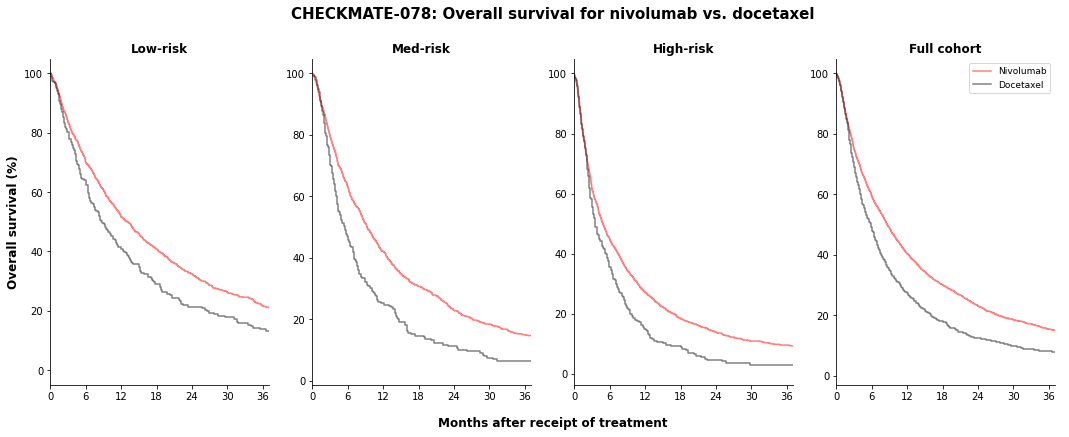

In [290]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low-risk group. 
plt.subplot(1, 4, 1)

time_low_nivo, survival_prob_low_nivo = kaplan_meier_estimator(np.array(checkmate.loc[check_low_nivo]['death_status']),
                                                               np.array(checkmate.loc[check_low_nivo]['timerisk_treatment']))

time_low_dotx, survival_prob_low_dotx = kaplan_meier_estimator(np.array(checkmate.loc[check_low_dotx]['death_status']),
                                                               np.array(checkmate.loc[check_low_dotx]['timerisk_treatment']))

plt.step(time_low_nivo/30, survival_prob_low_nivo*100, color = 'red', alpha = 0.5)

plt.step(time_low_dotx/30, survival_prob_low_dotx*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for fairly low-risk group. 
plt.subplot(1, 4, 2)

time_med_nivo, survival_prob_med_nivo = kaplan_meier_estimator(np.array(checkmate.loc[check_med_nivo]['death_status']),
                                                               np.array(checkmate.loc[check_med_nivo]['timerisk_treatment']))

time_med_dotx, survival_prob_med_dotx = kaplan_meier_estimator(np.array(checkmate.loc[check_med_dotx]['death_status']),
                                                               np.array(checkmate.loc[check_med_dotx]['timerisk_treatment']))

plt.step(time_med_nivo/30, survival_prob_med_nivo*100, color = 'red', alpha = 0.5)

plt.step(time_med_dotx/30, survival_prob_med_dotx*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high-risk group. 
plt.subplot(1, 4, 3)

time_high_nivo, survival_prob_high_nivo = kaplan_meier_estimator(np.array(checkmate.loc[check_high_nivo]['death_status']),
                                                                 np.array(checkmate.loc[check_high_nivo]['timerisk_treatment']))

time_high_dotx, survival_prob_high_dotx = kaplan_meier_estimator(np.array(checkmate.loc[check_high_dotx]['death_status']),
                                                                 np.array(checkmate.loc[check_high_dotx]['timerisk_treatment']))

plt.step(time_high_nivo/30, survival_prob_high_nivo*100, color = 'red', alpha = 0.5)

plt.step(time_high_dotx/30, survival_prob_high_dotx*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all. 
plt.subplot(1, 4, 4)

time_all_nivo, survival_prob_all_nivo = kaplan_meier_estimator(np.array(checkmate.loc[check_all_nivo]['death_status']),
                                                               np.array(checkmate.loc[check_all_nivo]['timerisk_treatment']))

time_all_dotx, survival_prob_all_dotx = kaplan_meier_estimator(np.array(checkmate.loc[check_all_dotx]['death_status']),
                                                               np.array(checkmate.loc[check_all_dotx]['timerisk_treatment']))

plt.step(time_all_nivo/30, survival_prob_all_nivo*100, color = 'red', alpha = 0.5, label = 'Nivolumab')

plt.step(time_all_dotx/30, survival_prob_all_dotx*100, color = 'black', alpha = 0.5, label = 'Docetaxel')

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after receipt of treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHECKMATE-078: Overall survival for nivolumab vs. docetaxel', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival curves with confounder adjustment via IPTW

In [291]:
check_iptw = checkmate.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'nivo',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'steroid_diag',
                                       'opioid_PO_diag',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'pdl1_n',
                                       'risk_score'])

In [292]:
check_iptw.dtypes

death_status             bool
timerisk_treatment    float64
nivo                    int64
age                     int64
gender                 object
race                   object
PracticeType           object
Histology              object
adv_year                int64
steroid_diag          float64
opioid_PO_diag        float64
commercial            float64
medicare              float64
medicaid              float64
pdl1_n                 object
risk_score            float64
dtype: object

In [293]:
to_be_categorical = list(check_iptw.select_dtypes(include = ['object']).columns)

In [294]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology', 'pdl1_n']

In [295]:
to_be_categorical.append('adv_year')

In [296]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    check_iptw[x] = check_iptw[x].astype('category')

In [297]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [298]:
# List of categorical features.
categorical_features = list(check_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [299]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [300]:
check_iptw_low = (
    check_iptw
    .query('risk_score <= @low_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_med = (
    check_iptw
    .query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_high = (
    check_iptw
    .query('risk_score >= @high_cutoff_078')
    .drop(columns = ['risk_score']))

In [301]:
check_low_x = preprocessor.fit_transform(check_iptw_low.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'adv_year',
                                                                        'steroid_diag',
                                                                        'opioid_PO_diag',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'pdl1_n']))

check_med_x = preprocessor.fit_transform(check_iptw_med.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'adv_year',
                                                                        'steroid_diag',
                                                                        'opioid_PO_diag',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'pdl1_n']))

check_high_x = preprocessor.fit_transform(check_iptw_high.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'steroid_diag',
                                                                          'opioid_PO_diag',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'pdl1_n']))

In [302]:
lr_check_low = LogisticRegression(max_iter = 1000)
lr_check_low.fit(check_low_x, check_iptw_low['nivo'])

LogisticRegression(max_iter=1000)

In [303]:
lr_check_med = LogisticRegression(max_iter = 1000)
lr_check_med.fit(check_med_x, check_iptw_med['nivo'])

LogisticRegression(max_iter=1000)

In [304]:
lr_check_high = LogisticRegression(max_iter = 1000)
lr_check_high.fit(check_high_x, check_iptw_high['nivo'])

LogisticRegression(max_iter=1000)

In [305]:
pred_low = lr_check_low.predict_proba(check_low_x)
pred_med = lr_check_med.predict_proba(check_med_x)
pred_high = lr_check_high.predict_proba(check_high_x)

In [306]:
check_iptw_low['ps'] = pred_low[:, 1]
check_iptw_med['ps'] = pred_med[:, 1]
check_iptw_high['ps'] = pred_high[:, 1]

In [307]:
check_iptw_low['weight'] = (
    np.where(check_iptw_low['nivo'] == 1, 1/check_iptw_low['ps'], 1/(1 - check_iptw_low['ps'])))

check_iptw_med['weight'] = (
    np.where(check_iptw_med['nivo'] == 1, 1/check_iptw_med['ps'], 1/(1 - check_iptw_med['ps'])))

check_iptw_high['weight'] = (
    np.where(check_iptw_high['nivo'] == 1, 1/check_iptw_high['ps'], 1/(1 - check_iptw_high['ps'])))

In [308]:
check_iptw_all = pd.concat([check_iptw_low, check_iptw_med, check_iptw_high])

In [309]:
# Low KM curves
kmf_low_nivo_check_iptw = KaplanMeierFitter()
kmf_low_dotx_check_iptw = KaplanMeierFitter()

kmf_low_nivo_check_iptw.fit(
    check_iptw_low.query('nivo == 1').timerisk_treatment/30,
    check_iptw_low.query('nivo == 1').death_status,
    weights = check_iptw_low.query('nivo == 1')['weight'])

kmf_low_dotx_check_iptw.fit(
    check_iptw_low.query('nivo == 0').timerisk_treatment/30,
    check_iptw_low.query('nivo == 0').death_status,
    weights = check_iptw_low.query('nivo == 0')['weight'])

# Med KM curves
kmf_med_nivo_check_iptw = KaplanMeierFitter()
kmf_med_dotx_check_iptw = KaplanMeierFitter()

kmf_med_nivo_check_iptw.fit(
    check_iptw_med.query('nivo == 1').timerisk_treatment/30,
    check_iptw_med.query('nivo == 1').death_status,
    weights = check_iptw_med.query('nivo == 1')['weight'])

kmf_med_dotx_check_iptw.fit(
    check_iptw_med.query('nivo == 0').timerisk_treatment/30,
    check_iptw_med.query('nivo == 0').death_status,
    weights = check_iptw_med.query('nivo == 0')['weight'])

# High KM curves 
kmf_high_nivo_check_iptw = KaplanMeierFitter()
kmf_high_dotx_check_iptw = KaplanMeierFitter()

kmf_high_nivo_check_iptw.fit(
    check_iptw_high.query('nivo == 1').timerisk_treatment/30,
    check_iptw_high.query('nivo == 1').death_status,
    weights = check_iptw_high.query('nivo == 1')['weight'])

kmf_high_dotx_check_iptw.fit(
    check_iptw_high.query('nivo == 0').timerisk_treatment/30,
    check_iptw_high.query('nivo == 0').death_status,
    weights = check_iptw_high.query('nivo == 0')['weight'])

# All KM curves 
kmf_all_nivo_check_iptw = KaplanMeierFitter()
kmf_all_dotx_check_iptw = KaplanMeierFitter()

kmf_all_nivo_check_iptw.fit(
    check_iptw_all.query('nivo == 1').timerisk_treatment/30,
    check_iptw_all.query('nivo == 1').death_status,
    weights = check_iptw_all.query('nivo == 1')['weight'])

kmf_all_dotx_check_iptw.fit(
    check_iptw_all.query('nivo == 0').timerisk_treatment/30,
    check_iptw_all.query('nivo == 0').death_status,
    weights = check_iptw_all.query('nivo == 0')['weight'])

/Applications/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3573.81 total observations, 456.554 right-censored observations>

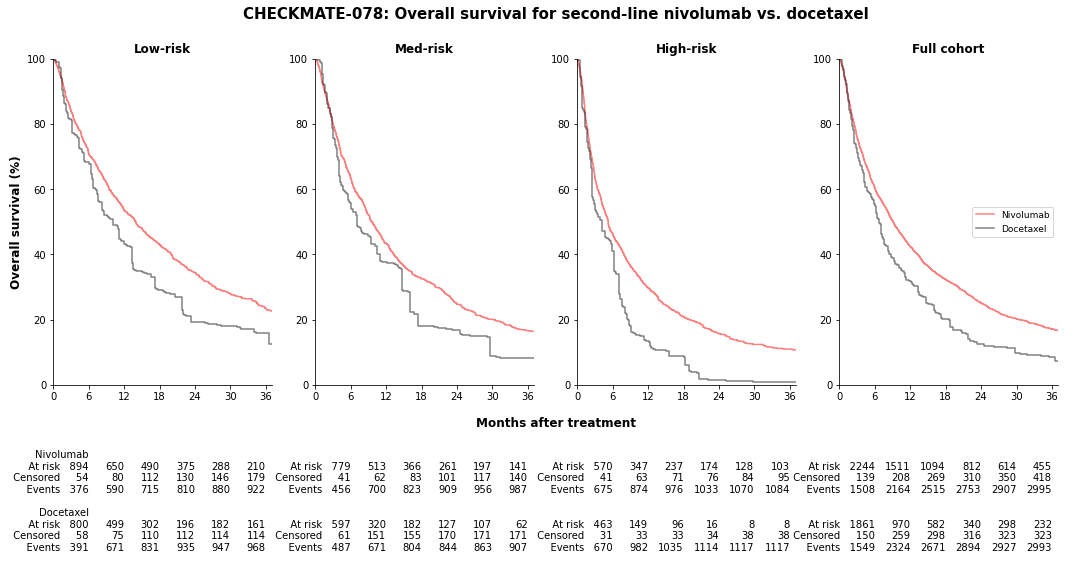

In [310]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_nivo_check_iptw.timeline, kmf_low_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_low_nivo_check_iptw.confidence_interval_.index, np.array(kmf_low_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_low_nivo_check_iptw.confidence_interval_.index, np.array(kmf_low_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_low_nivo_check_iptw.timeline, np.array(kmf_low_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_dotx_check_iptw.timeline, kmf_low_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_low_dotx_check_iptw.confidence_interval_.index, np.array(kmf_low_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_low_dotx_check_iptw.confidence_interval_.index, np.array(kmf_low_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_low_dotx_check_iptw.timeline, np.array(kmf_low_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_nivo_check_iptw, kmf_low_dotx_check_iptw, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = ['Nivolumab', 'Docetaxel'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_nivo_check_iptw.timeline, kmf_med_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_med_nivo_check_iptw.confidence_interval_.index, np.array(kmf_med_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_med_nivo_check_iptw.confidence_interval_.index, np.array(kmf_med_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_med_nivo_check_iptw.timeline, np.array(kmf_med_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_dotx_check_iptw.timeline, kmf_med_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_med_dotx_check_iptw.confidence_interval_.index, np.array(kmf_med_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_med_dotx_check_iptw.confidence_interval_.index, np.array(kmf_med_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_med_dotx_check_iptw.timeline, np.array(kmf_med_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_nivo_check_iptw, kmf_med_dotx_check_iptw, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_nivo_check_iptw.timeline, kmf_high_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_high_nivo_check_iptw.confidence_interval_.index, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_high_nivo_check_iptw.confidence_interval_.index, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_high_nivo_check_iptw.timeline, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_dotx_check_iptw.timeline, kmf_high_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_high_dotx_check_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_high_dotx_check_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_high_dotx_check_iptw.timeline[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_nivo_check_iptw, kmf_high_dotx_check_iptw, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_nivo_check_iptw.timeline, kmf_all_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Nivolumab')
#plt.step(kmf_all_nivo_check_iptw.confidence_interval_.index, np.array(kmf_all_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_all_nivo_check_iptw.confidence_interval_.index, np.array(kmf_all_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_all_nivo_check_iptw.timeline, np.array(kmf_all_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_dotx_check_iptw.timeline, kmf_all_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Docetaxel')
#plt.step(kmf_all_dotx_check_iptw.confidence_interval_.index, np.array(kmf_all_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_all_dotx_check_iptw.confidence_interval_.index, np.array(kmf_all_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_all_dotx_check_iptw.timeline, np.array(kmf_all_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_nivo_check_iptw, kmf_all_dotx_check_iptw, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHECKMATE-078: Overall survival for second-line nivolumab vs. docetaxel', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [311]:
nivo_check_12_os = psurv_t(kmf_low_nivo_check_iptw, 
                           kmf_med_nivo_check_iptw,
                           kmf_high_nivo_check_iptw,
                           12)

dotx_check_12_os = psurv_t(kmf_low_dotx_check_iptw,
                           kmf_med_dotx_check_iptw,
                           kmf_high_dotx_check_iptw,
                           12)

nivo_check_24_os = psurv_t(kmf_low_nivo_check_iptw, 
                           kmf_med_nivo_check_iptw,
                           kmf_high_nivo_check_iptw,
                           24)

dotx_check_24_os = psurv_t(kmf_low_dotx_check_iptw,
                           kmf_med_dotx_check_iptw,
                           kmf_high_dotx_check_iptw,
                           24)

nivo_check_median_os = mos(kmf_low_nivo_check_iptw, 
                           kmf_med_nivo_check_iptw,
                           kmf_high_nivo_check_iptw,
                           kmf_all_nivo_check_iptw)

dotx_check_median_os = mos(kmf_low_dotx_check_iptw,
                           kmf_med_dotx_check_iptw,
                           kmf_high_dotx_check_iptw,
                           kmf_all_dotx_check_iptw)

In [312]:
print('All, nivo: ',truncate(nivo_check_median_os[3], 3))
print('All, dotx: ',truncate(dotx_check_median_os[3], 3))

print('Low, nivo: ',truncate(nivo_check_median_os[0], 3))
print('Low, dotx: ',truncate(dotx_check_median_os[0], 3))

print('Med, nivo: ',truncate(nivo_check_median_os[1], 3))
print('Med, dotx: ',truncate(dotx_check_median_os[1], 3))

print('High, nivo: ',truncate(nivo_check_median_os[2], 3))
print('High, dotx: ',truncate(dotx_check_median_os[2], 3))

All, nivo:  9.133
All, dotx:  6.733
Low, nivo:  14.0
Low, dotx:  10.1
Med, nivo:  9.633
Med, dotx:  7.1
High, nivo:  5.233
High, dotx:  4.166


In [313]:
nivo_check_low_12_ci = psurv_ci(kmf_low_nivo_check_iptw, 12)
nivo_check_med_12_ci = psurv_ci(kmf_med_nivo_check_iptw, 12)
nivo_check_high_12_ci = psurv_ci(kmf_high_nivo_check_iptw, 12)

y_error_nivo_check_12 = y_error(nivo_check_low_12_ci,
                                nivo_check_med_12_ci,
                                nivo_check_high_12_ci,
                                nivo_check_12_os)

In [314]:
dotx_check_low_12_ci = psurv_ci(kmf_low_dotx_check_iptw, 12)
dotx_check_med_12_ci = psurv_ci(kmf_med_dotx_check_iptw, 12)
dotx_check_high_12_ci = psurv_ci(kmf_high_dotx_check_iptw, 12)

y_error_dotx_check_12 = y_error(dotx_check_low_12_ci,
                                dotx_check_med_12_ci,
                                dotx_check_high_12_ci,
                                dotx_check_12_os)

In [315]:
nivo_check_low_24_ci = psurv_ci(kmf_low_nivo_check_iptw, 24)
nivo_check_med_24_ci = psurv_ci(kmf_med_nivo_check_iptw, 24)
nivo_check_high_24_ci = psurv_ci(kmf_high_nivo_check_iptw, 24)

y_error_nivo_check_24 = y_error(nivo_check_low_24_ci,
                                nivo_check_med_24_ci,
                                nivo_check_high_24_ci,
                                nivo_check_24_os)

In [316]:
dotx_check_low_24_ci = psurv_ci(kmf_low_dotx_check_iptw, 24)
dotx_check_med_24_ci = psurv_ci(kmf_med_dotx_check_iptw, 24)
dotx_check_high_24_ci = psurv_ci(kmf_high_dotx_check_iptw, 24)

y_error_dotx_check_24 = y_error(dotx_check_low_24_ci,
                                dotx_check_med_24_ci,
                                dotx_check_high_24_ci,
                                dotx_check_24_os)

In [317]:
nivo_check_low_mos_ci = mos_ci(kmf_low_nivo_check_iptw)
nivo_check_med_mos_ci = mos_ci(kmf_med_nivo_check_iptw)
nivo_check_high_mos_ci = mos_ci(kmf_high_nivo_check_iptw)

y_error_nivo_check_mos = y_error(nivo_check_low_mos_ci,
                                 nivo_check_med_mos_ci,
                                 nivo_check_high_mos_ci, 
                                 nivo_check_median_os)

In [318]:
dotx_check_low_mos_ci = mos_ci(kmf_low_dotx_check_iptw)
dotx_check_med_mos_ci = mos_ci(kmf_med_dotx_check_iptw)
dotx_check_high_mos_ci = mos_ci(kmf_high_dotx_check_iptw)

y_error_dotx_check_mos = y_error(dotx_check_low_mos_ci,
                                 dotx_check_med_mos_ci,
                                 dotx_check_high_mos_ci,
                                 dotx_check_median_os)

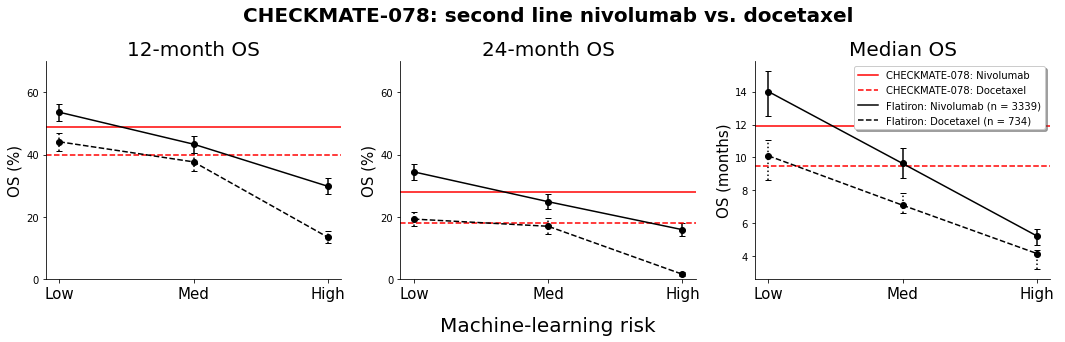

In [319]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, nivo_check_12_os, yerr = y_error_nivo_check_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 49, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, dotx_check_12_os, yerr = y_error_dotx_check_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 40, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 70)
plt.ylabel('OS (%)', size = 15)

plt.title('12-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, nivo_check_24_os, yerr = y_error_nivo_check_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 28, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, dotx_check_24_os, yerr = y_error_dotx_check_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 18, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 70)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, nivo_check_median_os[0:3], yerr = y_error_nivo_check_mos, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 11.9, color = 'red', linestyle = 'solid')

eb3 = plt.errorbar(ml_risk, dotx_check_median_os[0:3], yerr = y_error_dotx_check_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')
plt.axhline(y = 9.5, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('CHECKMATE-078: second line nivolumab vs. docetaxel', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'CHECKMATE-078: Nivolumab'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'CHECKMATE-078: Docetaxel'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Nivolumab (n = {})'.format(checkmate.query('nivo == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Docetaxel (n = {})'.format(checkmate.query('nivo == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'upper right', prop = {'size': 10})

#plt.savefig('check078_summary_rc.png', bbox_inches = 'tight')

plt.show()

## FLAURA: osimertinib vs. gefitinib or erlotinib

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line osimertinib or gefitinib or erlotinib

#### Osimertinib

In [320]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [321]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [322]:
flaura_osim = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Osimertinib"')
    [['PatientID', 'StartDate']]
)

In [323]:
flaura_osim.loc[:, 'osim'] = 1

In [324]:
row_ID(flaura_osim)

(1241, 1241)

#### Gefitinib or Erlotinib

In [325]:
flaura_gefer = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Gefitinib" or LineName == "Erlotinib"')
    [['PatientID', 'StartDate']]
)

In [326]:
flaura_gefer.loc[:, 'osim'] = 0

In [327]:
row_ID(flaura_gefer)

(3003, 3003)

In [328]:
flaura = pd.concat([flaura_osim, flaura_gefer])

In [329]:
row_ID(flaura)

(4244, 4244)

In [330]:
flaura = pd.merge(flaura, df_full, on = 'PatientID', how = 'inner')

In [331]:
row_ID(flaura)

(4244, 4244)

In [332]:
flaura['StartDate'] = pd.to_datetime(flaura['StartDate'])

#### Time from treatment to death or censor 

In [333]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [334]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [335]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [336]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [337]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [338]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [339]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [340]:
flaura = pd.merge(flaura, mortality, on = 'PatientID')

In [341]:
row_ID(flaura)

(4244, 4244)

In [342]:
conditions = [
    (flaura['death_status'] == 1),
    (flaura['death_status'] == 0)]

choices = [
    (flaura['death_date'] - flaura['StartDate']).dt.days,
    (flaura['last_activity'] - flaura['StartDate']).dt.days]

flaura.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [343]:
flaura = flaura.query('timerisk_treatment >= 0')

#### Patient count

In [344]:
low_cutoff_fl = flaura.risk_score.quantile(1/3)

In [345]:
high_cutoff_fl = flaura.risk_score.quantile(2/3)

In [346]:
print('Osimertinib total:', flaura.query('osim == 1').shape[0])
print('High risk:', flaura.query('osim == 1').query('risk_score >= @high_cutoff_fl').shape[0])
print('Med risk:', flaura.query('osim == 1').query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl').shape[0])
print('Low risk:', flaura.query('osim == 1').query('risk_score <= @low_cutoff_fl').shape[0])

Osimertinib total: 1239
High risk: 329
Med risk: 397
Low risk: 513


In [347]:
print('Gefitinib or Erlotinib total:', flaura.query('osim == 0').shape[0])
print('High risk:', flaura.query('osim == 0').query('risk_score >= @high_cutoff_fl').shape[0])
print('Med risk:', flaura.query('osim == 0').query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl').shape[0])
print('Low risk:', flaura.query('osim == 0').query('risk_score <= @low_cutoff_fl').shape[0])

Gefitinib or Erlotinib total: 3000
High risk: 1084
Med risk: 1016
Low risk: 900


In [348]:
risk_cutoff_lung.loc['flaura'] = [low_cutoff_fl, high_cutoff_fl]

In [349]:
risk_cutoff_lung

,low,high
keynote_042,-0.426139,0.115669
keynote_024,-0.290422,0.260603
keynote_189,-0.226867,0.323148
checkmate_078,-0.381083,0.090722
flaura,-0.748195,-0.239685


In [350]:
risk_cutoff_lung.to_csv('risk_cutoff_lung.csv', index = True)

#### Overall survival curves without confounder adjustment 

In [351]:
flaura = flaura.set_index('PatientID')

In [352]:
flaura_low_osim = (
    flaura
    .query('osim == 1')
    .query('risk_score <= @low_cutoff_fl')
    .index)

flaura_low_gefer = (
    flaura
    .query('osim == 0')
    .query('risk_score <= @low_cutoff_fl')
    .index)

flaura_med_osim = (
    flaura
    .query('osim == 1')
    .query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl')
    .index)

flaura_med_gefer = (
    flaura
    .query('osim == 0')
    .query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl')
    .index)

flaura_high_osim = (
    flaura
    .query('osim == 1')
    .query('risk_score >= @high_cutoff_fl')
    .index)

flaura_high_gefer = (
    flaura
    .query('osim == 0')
    .query('risk_score >= @high_cutoff_fl')
    .index)

flaura_all_osim = (
    flaura
    .query('osim == 1')
    .index)

flaura_all_gefer = (
    flaura
    .query('osim == 0')
    .index)

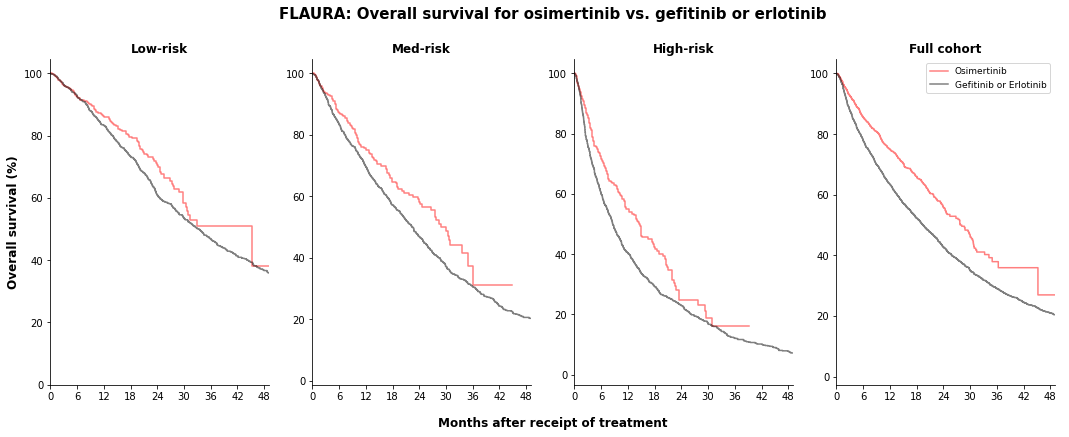

In [353]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low-risk group. 
plt.subplot(1, 4, 1)

time_low_osim, survival_prob_low_osim = kaplan_meier_estimator(np.array(flaura.loc[flaura_low_osim]['death_status']),
                                                               np.array(flaura.loc[flaura_low_osim]['timerisk_treatment']))

time_low_gefer, survival_prob_low_gefer = kaplan_meier_estimator(np.array(flaura.loc[flaura_low_gefer]['death_status']),
                                                                 np.array(flaura.loc[flaura_low_gefer]['timerisk_treatment']))

plt.step(time_low_osim/30, survival_prob_low_osim*100, color = 'red', alpha = 0.5)

plt.step(time_low_gefer/30, survival_prob_low_gefer*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 49, 6))
plt.xlim(0, 49)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for fairly low-risk group. 
plt.subplot(1, 4, 2)

time_med_osim, survival_prob_med_osim = kaplan_meier_estimator(np.array(flaura.loc[flaura_med_osim]['death_status']),
                                                               np.array(flaura.loc[flaura_med_osim]['timerisk_treatment']))

time_med_gefer, survival_prob_med_gefer = kaplan_meier_estimator(np.array(flaura.loc[flaura_med_gefer]['death_status']),
                                                                 np.array(flaura.loc[flaura_med_gefer]['timerisk_treatment']))

plt.step(time_med_osim/30, survival_prob_med_osim*100, color = 'red', alpha = 0.5)

plt.step(time_med_gefer/30, survival_prob_med_gefer*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 49, 6))
plt.xlim(0, 49)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high-risk group. 
plt.subplot(1, 4, 3)

time_high_osim, survival_prob_high_osim = kaplan_meier_estimator(np.array(flaura.loc[flaura_high_osim]['death_status']),
                                                                 np.array(flaura.loc[flaura_high_osim]['timerisk_treatment']))

time_high_gefer, survival_prob_high_gefer = kaplan_meier_estimator(np.array(flaura.loc[flaura_high_gefer]['death_status']),
                                                                   np.array(flaura.loc[flaura_high_gefer]['timerisk_treatment']))

plt.step(time_high_osim/30, survival_prob_high_osim*100, color = 'red', alpha = 0.5)

plt.step(time_high_gefer/30, survival_prob_high_gefer*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 49, 6))
plt.xlim(0, 49)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all. 
plt.subplot(1, 4, 4)

time_all_osim, survival_prob_all_osim = kaplan_meier_estimator(np.array(flaura.loc[flaura_all_osim]['death_status']),
                                                               np.array(flaura.loc[flaura_all_osim]['timerisk_treatment']))

time_all_gefer, survival_prob_all_gefer = kaplan_meier_estimator(np.array(flaura.loc[flaura_all_gefer]['death_status']),
                                                                 np.array(flaura.loc[flaura_all_gefer]['timerisk_treatment']))

plt.step(time_all_osim/30, survival_prob_all_osim*100, color = 'red', alpha = 0.5, label = 'Osimertinib')

plt.step(time_all_gefer/30, survival_prob_all_gefer*100, color = 'black', alpha = 0.5, label = 'Gefitinib or Erlotinib')

plt.xticks(np.arange(0, 49, 6))
plt.xlim(0, 49)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after receipt of treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('FLAURA: Overall survival for osimertinib vs. gefitinib or erlotinib', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Overall survival curves with confounder adjustment via IPTW

In [354]:
flaura_iptw = flaura.filter(items = ['death_status',
                                     'timerisk_treatment',
                                     'osim',
                                     'age',
                                     'gender',
                                     'race',
                                     'PracticeType',
                                     'Histology',
                                     'adv_year',
                                     'commercial',
                                     'medicare',
                                     'medicaid',
                                     'risk_score'])

In [355]:
flaura_iptw.dtypes

death_status             bool
timerisk_treatment    float64
osim                    int64
age                     int64
gender                 object
race                   object
PracticeType           object
Histology              object
adv_year                int64
commercial            float64
medicare              float64
medicaid              float64
risk_score            float64
dtype: object

In [356]:
to_be_categorical = list(flaura_iptw.select_dtypes(include = ['object']).columns)

In [357]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology']

In [358]:
to_be_categorical.append('adv_year')

In [359]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    flaura_iptw[x] = flaura_iptw[x].astype('category')

In [360]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [361]:
# List of categorical features.
categorical_features = list(flaura_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [362]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [363]:
flaura_iptw_low = (
    flaura_iptw
    .query('risk_score <= @low_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_med = (
    flaura_iptw
    .query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_high = (
    flaura_iptw
    .query('risk_score >= @high_cutoff_fl')
    .drop(columns = ['risk_score']))

In [364]:
flaura_low_x = preprocessor.fit_transform(flaura_iptw_low.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'steroid_diag',
                                                                          'opioid_PO_diag',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid']))

flaura_med_x = preprocessor.fit_transform(flaura_iptw_med.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'steroid_diag',
                                                                          'opioid_PO_diag',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid']))

flaura_high_x = preprocessor.fit_transform(flaura_iptw_high.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'steroid_diag',
                                                                            'opioid_PO_diag',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid']))

In [365]:
lr_flaura_low = LogisticRegression(max_iter = 1000)
lr_flaura_low.fit(flaura_low_x, flaura_iptw_low['osim'])

LogisticRegression(max_iter=1000)

In [366]:
lr_flaura_med = LogisticRegression(max_iter = 1000)
lr_flaura_med.fit(flaura_med_x, flaura_iptw_med['osim'])

LogisticRegression(max_iter=1000)

In [367]:
lr_flaura_high = LogisticRegression(max_iter = 1000)
lr_flaura_high.fit(flaura_high_x, flaura_iptw_high['osim'])

LogisticRegression(max_iter=1000)

In [368]:
pred_low = lr_flaura_low.predict_proba(flaura_low_x)
pred_med = lr_flaura_med.predict_proba(flaura_med_x)
pred_high = lr_flaura_high.predict_proba(flaura_high_x)

In [369]:
flaura_iptw_low['ps'] = pred_low[:, 1]
flaura_iptw_med['ps'] = pred_med[:, 1]
flaura_iptw_high['ps'] = pred_high[:, 1]

In [370]:
flaura_iptw_low['weight'] = (
    np.where(flaura_iptw_low['osim'] == 1, 1/flaura_iptw_low['ps'], 1/(1 - flaura_iptw_low['ps'])))

flaura_iptw_med['weight'] = (
    np.where(flaura_iptw_med['osim'] == 1, 1/flaura_iptw_med['ps'], 1/(1 - flaura_iptw_med['ps'])))

flaura_iptw_high['weight'] = (
    np.where(flaura_iptw_high['osim'] == 1, 1/flaura_iptw_high['ps'], 1/(1 - flaura_iptw_high['ps'])))

In [371]:
flaura_iptw_all = pd.concat([flaura_iptw_low, flaura_iptw_med, flaura_iptw_high])

In [372]:
# Low KM curves
kmf_low_osim_flaura_iptw = KaplanMeierFitter()
kmf_low_gefer_flaura_iptw = KaplanMeierFitter()

kmf_low_osim_flaura_iptw.fit(
    flaura_iptw_low.query('osim == 1').timerisk_treatment/30,
    flaura_iptw_low.query('osim == 1').death_status,
    weights = flaura_iptw_low.query('osim == 1')['weight'])

kmf_low_gefer_flaura_iptw.fit(
    flaura_iptw_low.query('osim == 0').timerisk_treatment/30,
    flaura_iptw_low.query('osim == 0').death_status,
    weights = flaura_iptw_low.query('osim == 0')['weight'])

# Med KM curves
kmf_med_osim_flaura_iptw = KaplanMeierFitter()
kmf_med_gefer_flaura_iptw = KaplanMeierFitter()

kmf_med_osim_flaura_iptw.fit(
    flaura_iptw_med.query('osim == 1').timerisk_treatment/30,
    flaura_iptw_med.query('osim == 1').death_status,
    weights = flaura_iptw_med.query('osim == 1')['weight'])

kmf_med_gefer_flaura_iptw.fit(
    flaura_iptw_med.query('osim == 0').timerisk_treatment/30,
    flaura_iptw_med.query('osim == 0').death_status,
    weights = flaura_iptw_med.query('osim == 0')['weight'])

# High KM curves 
kmf_high_osim_flaura_iptw = KaplanMeierFitter()
kmf_high_gefer_flaura_iptw = KaplanMeierFitter()

kmf_high_osim_flaura_iptw.fit(
    flaura_iptw_high.query('osim == 1').timerisk_treatment/30,
    flaura_iptw_high.query('osim == 1').death_status,
    weights = flaura_iptw_high.query('osim == 1')['weight'])

kmf_high_gefer_flaura_iptw.fit(
    flaura_iptw_high.query('osim == 0').timerisk_treatment/30,
    flaura_iptw_high.query('osim == 0').death_status,
    weights = flaura_iptw_high.query('osim == 0')['weight'])

# All KM curves 
kmf_all_osim_flaura_iptw = KaplanMeierFitter()
kmf_all_gefer_flaura_iptw = KaplanMeierFitter()

kmf_all_osim_flaura_iptw.fit(
    flaura_iptw_all.query('osim == 1').timerisk_treatment/30,
    flaura_iptw_all.query('osim == 1').death_status,
    weights = flaura_iptw_all.query('osim == 1')['weight'])

kmf_all_gefer_flaura_iptw.fit(
    flaura_iptw_all.query('osim == 0').timerisk_treatment/30,
    flaura_iptw_all.query('osim == 0').death_status,
    weights = flaura_iptw_all.query('osim == 0')['weight'])

/Applications/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3771.02 total observations, 1093.73 right-censored observations>

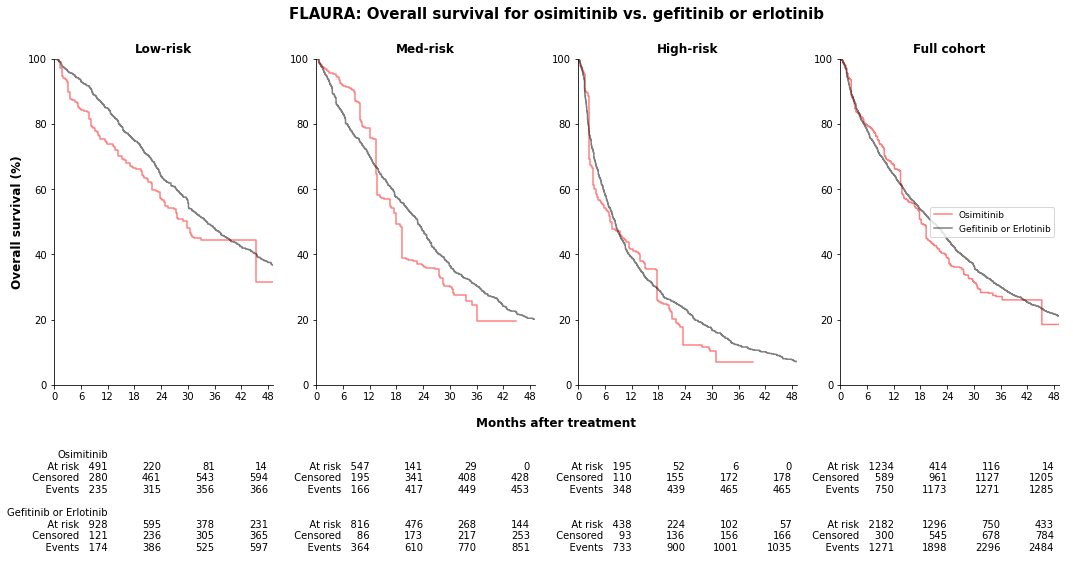

In [373]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_osim_flaura_iptw.timeline, kmf_low_osim_flaura_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_low_nivo_check_iptw.confidence_interval_.index, np.array(kmf_low_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_low_nivo_check_iptw.confidence_interval_.index, np.array(kmf_low_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_low_nivo_check_iptw.timeline, np.array(kmf_low_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_gefer_flaura_iptw.timeline, kmf_low_gefer_flaura_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_low_dotx_check_iptw.confidence_interval_.index, np.array(kmf_low_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_low_dotx_check_iptw.confidence_interval_.index, np.array(kmf_low_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_low_dotx_check_iptw.timeline, np.array(kmf_low_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 49, 6))
plt.xlim(0, 49)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_osim_flaura_iptw, kmf_low_gefer_flaura_iptw, ypos = -0.8, xticks = np.arange(12, 49, 12), labels = ['Osimitinib', 'Gefitinib or Erlotinib'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_osim_flaura_iptw.timeline, kmf_med_osim_flaura_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_med_nivo_check_iptw.confidence_interval_.index, np.array(kmf_med_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_med_nivo_check_iptw.confidence_interval_.index, np.array(kmf_med_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_med_nivo_check_iptw.timeline, np.array(kmf_med_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_gefer_flaura_iptw.timeline, kmf_med_gefer_flaura_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_med_dotx_check_iptw.confidence_interval_.index, np.array(kmf_med_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_med_dotx_check_iptw.confidence_interval_.index, np.array(kmf_med_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_med_dotx_check_iptw.timeline, np.array(kmf_med_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 49, 6))
plt.xlim(0, 49)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_osim_flaura_iptw, kmf_med_gefer_flaura_iptw, ypos = -0.8, xticks = np.arange(12, 49, 12), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_osim_flaura_iptw.timeline, kmf_high_osim_flaura_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_high_nivo_check_iptw.confidence_interval_.index, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_high_nivo_check_iptw.confidence_interval_.index, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_high_nivo_check_iptw.timeline, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_gefer_flaura_iptw.timeline, kmf_high_gefer_flaura_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_high_dotx_check_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_high_dotx_check_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_high_dotx_check_iptw.timeline[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 49, 6))
plt.xlim(0, 49)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_osim_flaura_iptw, kmf_high_gefer_flaura_iptw, ypos = -0.8, xticks = np.arange(12, 49, 12), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_osim_flaura_iptw.timeline, kmf_all_osim_flaura_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Osimitinib')
#plt.step(kmf_all_nivo_check_iptw.confidence_interval_.index, np.array(kmf_all_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_all_nivo_check_iptw.confidence_interval_.index, np.array(kmf_all_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_all_nivo_check_iptw.timeline, np.array(kmf_all_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_gefer_flaura_iptw.timeline, kmf_all_gefer_flaura_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Gefitinib or Erlotinib')
#plt.step(kmf_all_dotx_check_iptw.confidence_interval_.index, np.array(kmf_all_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_all_dotx_check_iptw.confidence_interval_.index, np.array(kmf_all_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_all_dotx_check_iptw.timeline, np.array(kmf_all_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 49, 6))
plt.xlim(0, 49)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_osim_flaura_iptw, kmf_all_gefer_flaura_iptw, ypos = -0.8, xticks = np.arange(12, 49, 12), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('FLAURA: Overall survival for osimitinib vs. gefitinib or erlotinib', pad = 40, size = 15, weight = 'bold')

plt.show()

#### rwPFS with confounder adjustment via IPTW

In [374]:
progression = pd.read_csv ('Enhanced_AdvNSCLCProgression.csv')

In [375]:
flaura = flaura.reset_index()

In [376]:
row_ID(flaura)

(4239, 4239)

In [377]:
progression = progression[progression.PatientID.isin(flaura.PatientID)][['PatientID', 'ProgressionDate']]

In [378]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [379]:
progression = (
    progression
    .sort_values(['PatientID', 'ProgressionDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [380]:
row_ID(progression)

(4238, 4238)

In [381]:
flaura = pd.merge(flaura, progression, on = 'PatientID')

In [382]:
row_ID(flaura)

(4238, 4238)

In [383]:
# Percent without progression date in Flaura trial
len(flaura.query('ProgressionDate.isna()', engine = 'python'))/len(flaura)

0.3433223218499292

In [384]:
conditions = [
    (flaura.ProgressionDate.notna()),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 1)),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 0))]

choices = [
    (flaura['ProgressionDate'] - flaura['StartDate']).dt.days,
    (flaura['death_date'] - flaura['StartDate']).dt.days,
    (flaura['last_activity'] - flaura['StartDate']).dt.days]

flaura.loc[:, 'time_prog_treatment'] = np.select(conditions, choices)

In [385]:
flaura = flaura.query('time_prog_treatment >= 0')

In [386]:
conditions = [
    (flaura.ProgressionDate.notna()),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 1)),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 0))]

choices = [1, 1, 0]

flaura.loc[:, 'pfs_status'] = np.select(conditions, choices)

In [387]:
flaura = flaura.set_index('PatientID')

In [388]:
flaura_iptw = flaura.filter(items = ['pfs_status',
                                     'time_prog_treatment',
                                     'osim',
                                     'age',
                                     'gender',
                                     'race',
                                     'PracticeType',
                                     'Histology',
                                     'adv_year',
                                     'commercial',
                                     'medicare',
                                     'medicaid',
                                     'risk_score'])

In [389]:
flaura_iptw.dtypes

pfs_status               int64
time_prog_treatment    float64
osim                     int64
age                      int64
gender                  object
race                    object
PracticeType            object
Histology               object
adv_year                 int64
commercial             float64
medicare               float64
medicaid               float64
risk_score             float64
dtype: object

In [390]:
to_be_categorical = list(flaura_iptw.select_dtypes(include = ['object']).columns)

In [391]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology']

In [392]:
to_be_categorical.append('adv_year')

In [393]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    flaura_iptw[x] = flaura_iptw[x].astype('category')

In [394]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [395]:
# List of categorical features.
categorical_features = list(flaura_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [396]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [397]:
flaura_iptw_low = (
    flaura_iptw
    .query('risk_score <= @low_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_med = (
    flaura_iptw
    .query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_high = (
    flaura_iptw
    .query('risk_score >= @high_cutoff_fl')
    .drop(columns = ['risk_score']))

In [398]:
flaura_low_x = preprocessor.fit_transform(flaura_iptw_low.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'steroid_diag',
                                                                          'opioid_PO_diag',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid']))

flaura_med_x = preprocessor.fit_transform(flaura_iptw_med.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'steroid_diag',
                                                                          'opioid_PO_diag',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid']))

flaura_high_x = preprocessor.fit_transform(flaura_iptw_high.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'steroid_diag',
                                                                            'opioid_PO_diag',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid']))

In [399]:
lr_flaura_low = LogisticRegression(max_iter = 1000)
lr_flaura_low.fit(flaura_low_x, flaura_iptw_low['osim'])

LogisticRegression(max_iter=1000)

In [400]:
lr_flaura_med = LogisticRegression(max_iter = 1000)
lr_flaura_med.fit(flaura_med_x, flaura_iptw_med['osim'])

LogisticRegression(max_iter=1000)

In [401]:
lr_flaura_high = LogisticRegression(max_iter = 1000)
lr_flaura_high.fit(flaura_high_x, flaura_iptw_high['osim'])

LogisticRegression(max_iter=1000)

In [402]:
pred_low = lr_flaura_low.predict_proba(flaura_low_x)
pred_med = lr_flaura_med.predict_proba(flaura_med_x)
pred_high = lr_flaura_high.predict_proba(flaura_high_x)

In [403]:
flaura_iptw_low['ps'] = pred_low[:, 1]
flaura_iptw_med['ps'] = pred_med[:, 1]
flaura_iptw_high['ps'] = pred_high[:, 1]

In [404]:
flaura_iptw_low['weight'] = (
    np.where(flaura_iptw_low['osim'] == 1, 1/flaura_iptw_low['ps'], 1/(1 - flaura_iptw_low['ps'])))

flaura_iptw_med['weight'] = (
    np.where(flaura_iptw_med['osim'] == 1, 1/flaura_iptw_med['ps'], 1/(1 - flaura_iptw_med['ps'])))

flaura_iptw_high['weight'] = (
    np.where(flaura_iptw_high['osim'] == 1, 1/flaura_iptw_high['ps'], 1/(1 - flaura_iptw_high['ps'])))

In [405]:
flaura_iptw_all = pd.concat([flaura_iptw_low, flaura_iptw_med, flaura_iptw_high])

In [406]:
# Low KM curves
kmf_low_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_low_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_low_osim_flaura_iptw_pfs.fit(
    flaura_iptw_low.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_low.query('osim == 1').pfs_status,
    weights = flaura_iptw_low.query('osim == 1')['weight'])

kmf_low_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_low.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_low.query('osim == 0').pfs_status,
    weights = flaura_iptw_low.query('osim == 0')['weight'])

# Med KM curves
kmf_med_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_med_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_med_osim_flaura_iptw_pfs.fit(
    flaura_iptw_med.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_med.query('osim == 1').pfs_status,
    weights = flaura_iptw_med.query('osim == 1')['weight'])

kmf_med_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_med.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_med.query('osim == 0').pfs_status,
    weights = flaura_iptw_med.query('osim == 0')['weight'])

# High KM curves 
kmf_high_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_high_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_high_osim_flaura_iptw_pfs.fit(
    flaura_iptw_high.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_high.query('osim == 1').pfs_status,
    weights = flaura_iptw_high.query('osim == 1')['weight'])

kmf_high_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_high.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_high.query('osim == 0').pfs_status,
    weights = flaura_iptw_high.query('osim == 0')['weight'])

# All KM curves 
kmf_all_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_all_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_all_osim_flaura_iptw_pfs.fit(
    flaura_iptw_all.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_all.query('osim == 1').pfs_status,
    weights = flaura_iptw_all.query('osim == 1')['weight'])

kmf_all_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_all.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_all.query('osim == 0').pfs_status,
    weights = flaura_iptw_all.query('osim == 0')['weight'])

/Applications/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3173.42 total observations, 367.507 right-censored observations>

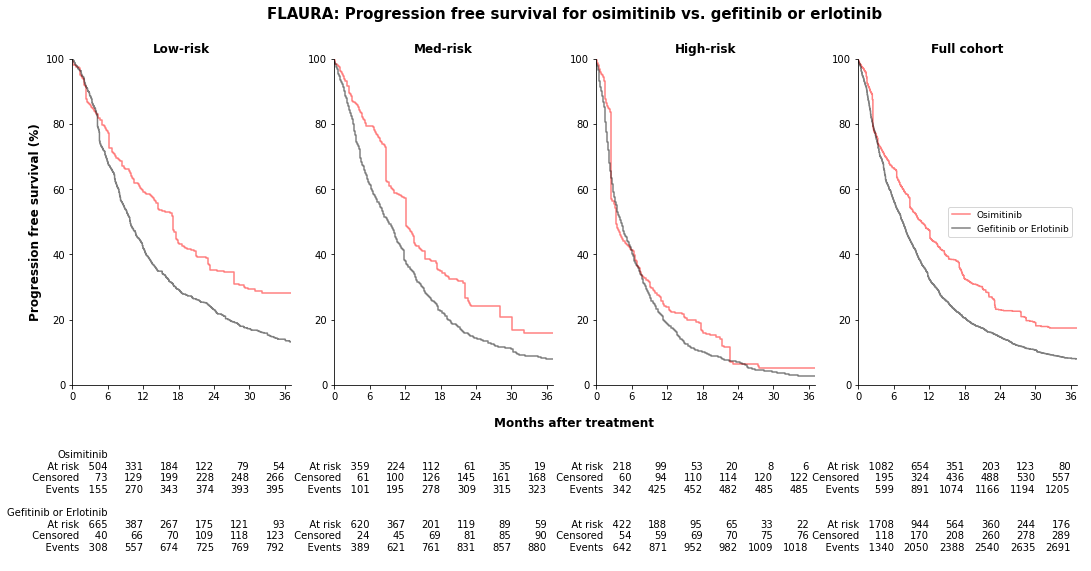

In [407]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_osim_flaura_iptw_pfs.timeline, kmf_low_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_low_osim_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_low_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_low_osim_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_low_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_low_osim_flaura_iptw_pfs.timeline, np.array(kmf_low_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_low_gefer_flaura_iptw_pfs.timeline, kmf_low_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_low_gefer_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_low_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_low_gefer_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_low_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_low_gefer_flaura_iptw_pfs.timeline, np.array(kmf_low_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_low_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Progression free survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_osim_flaura_iptw_pfs, kmf_low_gefer_flaura_iptw_pfs, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = ['Osimitinib', 'Gefitinib or Erlotinib'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_osim_flaura_iptw_pfs.timeline, kmf_med_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_med_osim_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_med_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_med_osim_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_med_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_med_osim_flaura_iptw_pfs.timeline, np.array(kmf_med_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_med_gefer_flaura_iptw_pfs.timeline, kmf_med_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_med_gefer_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_med_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_med_gefer_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_med_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_med_gefer_flaura_iptw_pfs.timeline, np.array(kmf_med_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_med_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_osim_flaura_iptw_pfs, kmf_med_gefer_flaura_iptw_pfs, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_osim_flaura_iptw_pfs.timeline, kmf_high_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)
#plt.step(kmf_high_nivo_check_iptw.confidence_interval_.index, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_high_nivo_check_iptw.confidence_interval_.index, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_high_nivo_check_iptw.timeline, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_high_nivo_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_high_gefer_flaura_iptw_pfs.timeline, kmf_high_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)
#plt.step(kmf_high_dotx_check_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_high_dotx_check_iptw.confidence_interval_.index[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_high_dotx_check_iptw.timeline[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_upper_0.95'])*100)[:-1], (np.array(kmf_high_dotx_check_iptw.confidence_interval_['KM_estimate_lower_0.95'])*100)[:-1], facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_osim_flaura_iptw_pfs, kmf_high_gefer_flaura_iptw_pfs, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_osim_flaura_iptw_pfs.timeline, kmf_all_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Osimitinib')
#plt.step(kmf_all_osim_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_all_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.step(kmf_all_osim_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_all_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'red', alpha = 0.3)
#plt.fill_between(kmf_all_osim_flaura_iptw_pfs.timeline, np.array(kmf_all_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_osim_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'red', alpha = 0.1)

plt.step(kmf_all_gefer_flaura_iptw_pfs.timeline, kmf_all_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Gefitinib or Erlotinib')
#plt.step(kmf_all_gefer_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_all_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.step(kmf_all_gefer_flaura_iptw_pfs.confidence_interval_.index, np.array(kmf_all_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, linestyle = '--', color = 'black', alpha = 0.3)
#plt.fill_between(kmf_all_gefer_flaura_iptw_pfs.timeline, np.array(kmf_all_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_upper_0.95'])*100, np.array(kmf_all_gefer_flaura_iptw_pfs.confidence_interval_['KM_estimate_lower_0.95'])*100, facecolor = 'black', alpha = 0.1)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_osim_flaura_iptw_pfs, kmf_all_gefer_flaura_iptw_pfs, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('FLAURA: Progression free survival for osimitinib vs. gefitinib or erlotinib', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [408]:
osim_flaura_12_pfs = psurv_t(kmf_low_osim_flaura_iptw_pfs,
                             kmf_med_osim_flaura_iptw_pfs,
                             kmf_high_osim_flaura_iptw_pfs,
                             12)

gefer_flaura_12_pfs = psurv_t(kmf_low_gefer_flaura_iptw_pfs,
                              kmf_med_gefer_flaura_iptw_pfs,
                              kmf_high_gefer_flaura_iptw_pfs,
                              12)

osim_flaura_24_pfs = psurv_t(kmf_low_osim_flaura_iptw_pfs,
                             kmf_med_osim_flaura_iptw_pfs,
                             kmf_high_osim_flaura_iptw_pfs,
                             24)

gefer_flaura_24_pfs = psurv_t(kmf_low_gefer_flaura_iptw_pfs,
                              kmf_med_gefer_flaura_iptw_pfs,
                              kmf_high_gefer_flaura_iptw_pfs,
                              24)

osim_flaura_median_pfs = mos(kmf_low_osim_flaura_iptw_pfs,
                             kmf_med_osim_flaura_iptw_pfs,
                             kmf_high_osim_flaura_iptw_pfs,
                             kmf_all_osim_flaura_iptw_pfs)

gefer_flaura_median_pfs = mos(kmf_low_gefer_flaura_iptw_pfs,
                              kmf_med_gefer_flaura_iptw_pfs,
                              kmf_high_gefer_flaura_iptw_pfs,
                              kmf_all_gefer_flaura_iptw_pfs)

In [409]:
print('All, osim: ',truncate(osim_flaura_median_pfs[3], 3))
print('All, gefer: ',truncate(gefer_flaura_median_pfs[3], 3))

print('Low, osim: ',truncate(osim_flaura_median_pfs[0], 3))
print('Low, gefer: ',truncate(gefer_flaura_median_pfs[0], 3))

print('Med, osim: ',truncate(osim_flaura_median_pfs[1], 3))
print('Med, gefer: ',truncate(gefer_flaura_median_pfs[1], 3))

print('High, osim: ',truncate(osim_flaura_median_pfs[2], 3))
print('High, gefer: ',truncate(gefer_flaura_median_pfs[2], 3))

All, osim:  10.733
All, gefer:  7.566
Low, osim:  17.133
Low, gefer:  9.866
Med, osim:  12.166
Med, gefer:  9.233
High, osim:  3.333
High, gefer:  4.233


In [410]:
osim_flaura_low_12_ci = psurv_ci(kmf_low_osim_flaura_iptw_pfs, 12)
osim_flaura_med_12_ci = psurv_ci(kmf_med_osim_flaura_iptw_pfs, 12)
osim_flaura_high_12_ci = psurv_ci(kmf_high_osim_flaura_iptw_pfs, 12)

y_error_osim_flaura_12 = y_error(osim_flaura_low_12_ci,
                                 osim_flaura_med_12_ci,
                                 osim_flaura_high_12_ci,
                                 osim_flaura_12_pfs)

In [411]:
gefer_flaura_low_12_ci = psurv_ci(kmf_low_gefer_flaura_iptw_pfs, 12)
gefer_flaura_med_12_ci = psurv_ci(kmf_med_gefer_flaura_iptw_pfs, 12)
gefer_flaura_high_12_ci = psurv_ci(kmf_high_gefer_flaura_iptw_pfs, 12)

y_error_gefer_flaura_12 = y_error(gefer_flaura_low_12_ci,
                                  gefer_flaura_med_12_ci,
                                  gefer_flaura_high_12_ci,
                                  gefer_flaura_12_pfs)

In [412]:
osim_flaura_low_24_ci = psurv_ci(kmf_low_osim_flaura_iptw_pfs, 24)
osim_flaura_med_24_ci = psurv_ci(kmf_med_osim_flaura_iptw_pfs, 24)
osim_flaura_high_24_ci = psurv_ci(kmf_high_osim_flaura_iptw_pfs, 24)

y_error_osim_flaura_24 = y_error(osim_flaura_low_24_ci,
                                 osim_flaura_med_24_ci,
                                 osim_flaura_high_24_ci,
                                 osim_flaura_24_pfs)

In [413]:
gefer_flaura_low_24_ci = psurv_ci(kmf_low_gefer_flaura_iptw_pfs, 24)
gefer_flaura_med_24_ci = psurv_ci(kmf_med_gefer_flaura_iptw_pfs, 24)
gefer_flaura_high_24_ci = psurv_ci(kmf_high_gefer_flaura_iptw_pfs, 24)

y_error_gefer_flaura_24 = y_error(gefer_flaura_low_24_ci,
                                  gefer_flaura_med_24_ci,
                                  gefer_flaura_high_24_ci,
                                  gefer_flaura_24_pfs)

In [414]:
osim_flaura_low_mpfs_ci = mos_ci(kmf_low_osim_flaura_iptw_pfs)
osim_flaura_med_mpfs_ci = mos_ci(kmf_med_osim_flaura_iptw_pfs)
osim_flaura_high_mpfs_ci = mos_ci(kmf_high_osim_flaura_iptw_pfs)

y_error_osim_flaura_mpfs = y_error(osim_flaura_low_mpfs_ci,
                                   osim_flaura_med_mpfs_ci,
                                   osim_flaura_high_mpfs_ci,
                                   osim_flaura_median_pfs)

In [415]:
gefer_flaura_low_mpfs_ci = mos_ci(kmf_low_gefer_flaura_iptw_pfs)
gefer_flaura_med_mpfs_ci = mos_ci(kmf_med_gefer_flaura_iptw_pfs)
gefer_flaura_high_mpfs_ci = mos_ci(kmf_high_gefer_flaura_iptw_pfs)

y_error_gefer_flaura_mpfs = y_error(gefer_flaura_low_mpfs_ci,
                                    gefer_flaura_med_mpfs_ci,
                                    gefer_flaura_high_mpfs_ci,
                                    gefer_flaura_median_pfs)

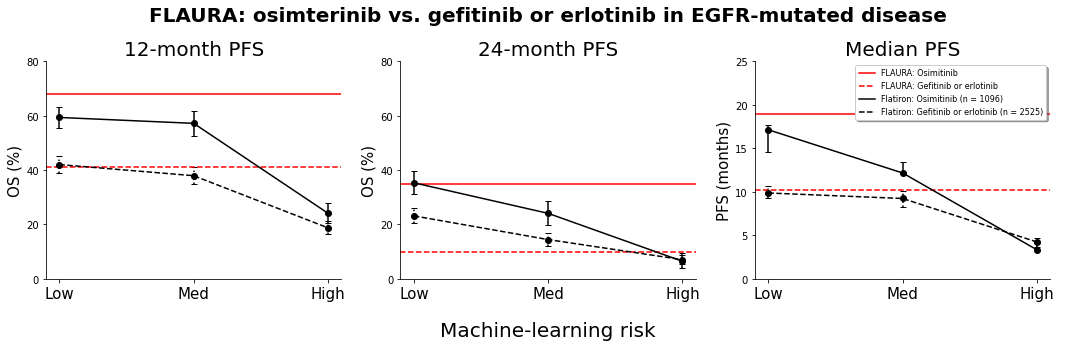

In [416]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month PFS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, osim_flaura_12_pfs, yerr = y_error_osim_flaura_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 68, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, gefer_flaura_12_pfs, yerr = y_error_gefer_flaura_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 41, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 80)
plt.ylabel('PFS (%)', size = 15)

plt.title('12-month PFS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month PFS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, osim_flaura_24_pfs, yerr = y_error_osim_flaura_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 35, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, gefer_flaura_24_pfs, yerr = y_error_gefer_flaura_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 10, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 80)
plt.ylabel('PFS (%)', size = 15)

plt.title('24-month PFS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median PFS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, osim_flaura_median_pfs[0:3], yerr = y_error_osim_flaura_mpfs, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 18.9, color = 'red', linestyle = 'solid')

eb3 = plt.errorbar(ml_risk, gefer_flaura_median_pfs[0:3], yerr = y_error_gefer_flaura_mpfs, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')
plt.axhline(y = 10.2, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.ylim(0, 25)
plt.ylabel('PFS (months)', size = 15)

plt.title('Median PFS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 25, size = 20)
plt.title('FLAURA: osimterinib vs. gefitinib or erlotinib in EGFR-mutated disease', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'FLAURA: Osimitinib'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'FLAURA: Gefitinib or erlotinib'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Osimitinib (n = {})'.format(flaura.query('osim == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Gefitinib or erlotinib (n = {})'.format(flaura.query('osim == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'upper right', prop = {'size': 8})

#plt.savefig('flaura_summary_rc.png', bbox_inches = 'tight')

plt.show()